# Generative Adversarial Networks (GANs)

So far in CS231N, all the applications of neural networks that we have explored have been **discriminative models** that take an input and are trained to produce a labeled output. This has ranged from straightforward classification of image categories to sentence generation (which was still phrased as a classification problem, our labels were in vocabulary space and we’d learned a recurrence to capture multi-word labels). In this notebook, we will expand our repetoire, and build **generative models** using neural networks. Specifically, we will learn how to build models which generate novel images that resemble a set of training images.

### What is a GAN?

In 2014, [Goodfellow et al.](https://arxiv.org/abs/1406.2661) presented a method for training generative models called Generative Adversarial Networks (GANs for short). In a GAN, we build two different neural networks. Our first network is a traditional classification network, called the **discriminator**. We will train the discriminator to take images, and classify them as being real (belonging to the training set) or fake (not present in the training set). Our other network, called the **generator**, will take random noise as input and transform it using a neural network to produce images. The goal of the generator is to fool the discriminator into thinking the images it produced are real.

We can think of this back and forth process of the generator ($G$) trying to fool the discriminator ($D$), and the discriminator trying to correctly classify real vs. fake as a minimax game:
$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
where $x \sim p_\text{data}$ are samples from the input data, $z \sim p(z)$ are the random noise samples, $G(z)$ are the generated images using the neural network generator $G$, and $D$ is the output of the discriminator, specifying the probability of an input being real. In [Goodfellow et al.](https://arxiv.org/abs/1406.2661), they analyze this minimax game and show how it relates to minimizing the Jensen-Shannon divergence between the training data distribution and the generated samples from $G$.

To optimize this minimax game, we will aternate between taking gradient *descent* steps on the objective for $G$, and gradient *ascent* steps on the objective for $D$:
1. update the **generator** ($G$) to minimize the probability of the __discriminator making the correct choice__. 
2. update the **discriminator** ($D$) to maximize the probability of the __discriminator making the correct choice__.

While these updates are useful for analysis, they do not perform well in practice. Instead, we will use a different objective when we update the generator: maximize the probability of the **discriminator making the incorrect choice**. This small change helps to allevaiate problems with the generator gradient vanishing when the discriminator is confident. This is the standard update used in most GAN papers, and was used in the original paper from [Goodfellow et al.](https://arxiv.org/abs/1406.2661). 

In this assignment, we will alternate the following updates:
1. Update the generator ($G$) to maximize the probability of the discriminator making the incorrect choice on generated data:
$$\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
2. Update the discriminator ($D$), to maximize the probability of the discriminator making the correct choice on real and generated data:
$$\underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

### What else is there?
Since 2014, GANs have exploded into a huge research area, with massive [workshops](https://sites.google.com/site/nips2016adversarial/), and [hundreds of new papers](https://github.com/hindupuravinash/the-gan-zoo). Compared to other approaches for generative models, they often produce the highest quality samples but are some of the most difficult and finicky models to train (see [this github repo](https://github.com/soumith/ganhacks) that contains a set of 17 hacks that are useful for getting models working). Improving the stabiilty and robustness of GAN training is an open research question, with new papers coming out every day! For a more recent tutorial on GANs, see [here](https://arxiv.org/abs/1701.00160). There is also some even more recent exciting work that changes the objective function to Wasserstein distance and yields much more stable results across model architectures: [WGAN](https://arxiv.org/abs/1701.07875), [WGAN-GP](https://arxiv.org/abs/1704.00028).


GANs are not the only way to train a generative model! For other approaches to generative modeling check out the [deep generative model chapter](http://www.deeplearningbook.org/contents/generative_models.html) of the Deep Learning [book](http://www.deeplearningbook.org). Another popular way of training neural networks as generative models is Variational Autoencoders (co-discovered [here](https://arxiv.org/abs/1312.6114) and [here](https://arxiv.org/abs/1401.4082)). Variational autoencoders combine neural networks with variational inference to train deep generative models. These models tend to be far more stable and easier to train but currently don't produce samples that are as pretty as GANs.

Example pictures of what you should expect (yours might look slightly different):

![caption](gan_outputs_tf.png)


## Setup

In [1]:
from __future__ import print_function, division
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# A bunch of utility functions

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params():
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(x.get_shape().as_list()) for x in tf.global_variables()])
    return param_count


def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

answers = np.load('gan-checks-tf.npz')


/home/sebastian/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Dataset
 GANs are notoriously finicky with hyperparameters, and also require many training epochs. In order to make this assignment approachable without a GPU, we will be working on the MNIST dataset, which is 60,000 training and 10,000 test images. Each picture contains a centered image of white digit on black background (0 through 9). This was one of the first datasets used to train convolutional neural networks and it is fairly easy -- a standard CNN model can easily exceed 99% accuracy. 

To simplify our code here, we will use the TensorFlow MNIST wrapper, which downloads and loads the MNIST dataset. See the [documentation](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/learn/python/learn/datasets/mnist.py) for more information about the interface. The default parameters will take 5,000 of the training examples and place them into a validation dataset. The data will be saved into a folder called `MNIST_data`. 

**Heads-up**: The TensorFlow MNIST wrapper returns images as vectors. That is, they're size (batch, 784). If you want to treat them as images, we have to resize them to (batch,28,28) or (batch,28,28,1). They are also type np.float32 and bounded [0,1]. 

Extracting ./cs231n/datasets/MNIST_data/train-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/t10k-labels-idx1-ubyte.gz


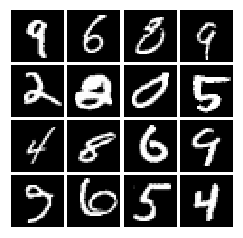

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./cs231n/datasets/MNIST_data', one_hot=False)

# show a batch
show_images(mnist.train.next_batch(16)[0])

## LeakyReLU
In the cell below, you should implement a LeakyReLU. See the [class notes](http://cs231n.github.io/neural-networks-1/) (where alpha is small number) or equation (3) in [this paper](http://ai.stanford.edu/~amaas/papers/relu_hybrid_icml2013_final.pdf). LeakyReLUs keep ReLU units from dying and are often used in GAN methods (as are maxout units, however those increase model size and therefore are not used in this notebook).

HINT: You should be able to use `tf.maximum`

In [3]:
def leaky_relu(x, alpha=0.01):
    """Compute the leaky ReLU activation function.
    
    Inputs:
    - x: TensorFlow Tensor with arbitrary shape
    - alpha: leak parameter for leaky ReLU
    
    Returns:
    TensorFlow Tensor with the same shape as x
    """
    # TODO: implement leaky ReLU
    return tf.maximum(x, x*alpha)


Test your leaky ReLU implementation. You should get errors < 1e-10

In [4]:
def test_leaky_relu(x, y_true):
    tf.reset_default_graph()
    with get_session() as sess:
        y_tf = leaky_relu(tf.constant(x))
        y = sess.run(y_tf)
        print('Maximum error: %g'%rel_error(y_true, y))

test_leaky_relu(answers['lrelu_x'], answers['lrelu_y'])

Maximum error: 0


## Random Noise
Generate a TensorFlow `Tensor` containing uniform noise from -1 to 1 with shape `[batch_size, dim]`.

In [5]:
def sample_noise(batch_size, dim):
    """Generate random uniform noise from -1 to 1.
    
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the the noise to generate
    
    Returns:
    TensorFlow Tensor containing uniform noise in [-1, 1] with shape [batch_size, dim]
    """
    # TODO: sample and return noise
    return  tf.random_uniform((batch_size, dim), -1, 1)


Make sure noise is the correct shape and type:

In [6]:
def test_sample_noise():
    batch_size = 3
    dim = 4
    tf.reset_default_graph()
    with get_session() as sess:
        z = sample_noise(batch_size, dim)
        # Check z has the correct shape
        assert z.get_shape().as_list() == [batch_size, dim]
        # Make sure z is a Tensor and not a numpy array
        assert isinstance(z, tf.Tensor)
        # Check that we get different noise for different evaluations
        z1 = sess.run(z)
        z2 = sess.run(z)
        assert not np.array_equal(z1, z2)
        # Check that we get the correct range
        assert np.all(z1 >= -1.0) and np.all(z1 <= 1.0)
        print("All tests passed!")
    
test_sample_noise()

All tests passed!


## Discriminator
Our first step is to build a discriminator. You should use the layers in `tf.layers` to build the model.
All fully connected layers should include bias terms.

Architecture:
 * Fully connected layer from size 784 to 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer from 256 to 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer from 256 to 1
 
The output of the discriminator should have shape `[batch_size, 1]`, and contain real numbers corresponding to the scores that each of the `batch_size` inputs is a real image.

In [7]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        h = tf.layers.dense(x, 256)
        h = leaky_relu(h, 0.01)
        h = tf.layers.dense(h, 256)
        h = leaky_relu(h, 0.01)
        h = tf.layers.dense(h, 1)
        logits = h
        return logits

Test to make sure the number of parameters in the discriminator is correct:

In [8]:
def test_discriminator(true_count=267009):
    tf.reset_default_graph()
    with get_session() as sess:
        y = discriminator(tf.ones((2, 784)))
        cur_count = count_params()
        if cur_count != true_count:
            print('Incorrect number of parameters in discriminator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
        else:
            print('Correct number of parameters in discriminator.')
        
test_discriminator()

Correct number of parameters in discriminator.


## Generator
Now to build a generator. You should use the layers in `tf.layers` to construct the model. All fully connected layers should include bias terms.

Architecture:
 * Fully connected layer from tf.shape(z)[1] (the number of noise dimensions) to 1024
 * ReLU
 * Fully connected layer from 1024 to 1024 
 * ReLU
 * Fully connected layer from 1024 to 784
 * TanH (To restrict the output to be [-1,1])

In [9]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        h = z
        h = tf.layers.dense(h, 1024)
        h = tf.nn.relu(h)
        h = tf.layers.dense(h, 1024)
        h = tf.nn.relu(h)
        h = tf.layers.dense(h, 784)
        h = tf.nn.tanh(h)
        return h

Test to make sure the number of parameters in the generator is correct:

In [10]:
def test_generator(true_count=1858320):
    tf.reset_default_graph()
    with get_session() as sess:
        y = generator(tf.ones((1, 4)))
        cur_count = count_params()
        if cur_count != true_count:
            print('Incorrect number of parameters in generator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
        else:
            print('Correct number of parameters in generator.')
        
test_generator()

Correct number of parameters in generator.


# GAN Loss

Compute the generator and discriminator loss. The generator loss is:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
Note that these are negated from the equations presented earlier as we will be *minimizing* these losses.

**HINTS**: Use [tf.ones_like](https://www.tensorflow.org/api_docs/python/tf/ones_like) and [tf.zeros_like](https://www.tensorflow.org/api_docs/python/tf/zeros_like) to generate labels for your discriminator. Use [sigmoid_cross_entropy loss](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) to help compute your loss function. Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing.

In [11]:
def gan_loss(logits_real, logits_fake):
    """Compute the GAN loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    D_loss = None
    G_loss = None
    
    D_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_real, 
                                                                    labels=tf.ones_like(logits_real)))\
           + tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake, 
                                                                    labels=tf.zeros_like(logits_fake)))
    
    
    G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake, 
                                                                    labels=tf.ones_like(logits_fake)))
    return D_loss, G_loss

Test your GAN loss. Make sure both the generator and discriminator loss are correct. You should see errors less than 1e-5.

In [12]:
def test_gan_loss(logits_real, logits_fake, d_loss_true, g_loss_true):
    tf.reset_default_graph()
    with get_session() as sess:
        d_loss, g_loss = sess.run(gan_loss(tf.constant(logits_real), tf.constant(logits_fake)))
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_gan_loss(answers['logits_real'], answers['logits_fake'],
              answers['d_loss_true'], answers['g_loss_true'])

Maximum error in d_loss: 0
Maximum error in g_loss: 0


# Optimizing our loss
Make an `AdamOptimizer` with a 1e-3 learning rate, beta1=0.5 to mininize G_loss and D_loss separately. The trick of decreasing beta was shown to be effective in helping GANs converge in the [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498) paper. In fact, with our current hyperparameters, if you set beta1 to the Tensorflow default of 0.9, there's a good chance your discriminator loss will go to zero and the generator will fail to learn entirely. In fact, this is a common failure mode in GANs; if your D(x) learns to be too fast (e.g. loss goes near zero), your G(z) is never able to learn. Often D(x) is trained with SGD with Momentum or RMSProp instead of Adam, but here we'll use Adam for both D(x) and G(z). 

In [13]:
# TODO: create an AdamOptimizer for D_solver and G_solver
def get_solvers(learning_rate=1e-3, beta1=0.5):
    """Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """
    D_solver = tf.train.AdamOptimizer(learning_rate, beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate, beta1)

    return D_solver, G_solver

## Putting it all together
Now just a bit of Lego Construction.. Read this section over carefully to understand how we'll be composing the generator and discriminator

In [14]:
tf.reset_default_graph()

# number of images for each batch
batch_size = 128
# our noise dimension
noise_dim = 96

# placeholder for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
# random noise fed into our generator
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 

# get our solver
D_solver, G_solver = get_solvers()

# get our loss
D_loss, G_loss = gan_loss(logits_real, logits_fake)

# setup training steps
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = None
G_extra_step = None
# D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'discriminator')
# G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'generator')


# Training a GAN!
Well that wasn't so hard, was it? In the iterations in the low 100s you should see black backgrounds, fuzzy shapes as you approach iteration 1000, and decent shapes, about half of which will be sharp and clearly recognizable as we pass 3000. In our case, we'll simply train D(x) and G(z) with one batch each every iteration. However, papers often experiment with different schedules of training D(x) and G(z), sometimes doing one for more steps than the other, or even training each one until the loss gets "good enough" and then switching to training the other. 

In [15]:
# a giant helper function
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=250, print_every=50, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    # compute the number of iterations we need
    max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    for it in range(max_iter):
        # every show often, show a sample result
        if it % show_every == 0:
            samples = sess.run(G_sample)
            fig = show_images(samples[:16])
            plt.show()
            print()
        # run a batch of data through the network
        minibatch,minbatch_y = mnist.train.next_batch(batch_size)
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch})
        _, G_loss_curr = sess.run([G_train_step, G_loss])

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}, D: {:.4}, G:{:.4}'.format(it,D_loss_curr,G_loss_curr))
    print('Final images')
    samples = sess.run(G_sample)

    fig = show_images(samples[:16])
    plt.show()

#### Train your GAN! This should take about 10 minutes on a CPU, or less than a minute on GPU.

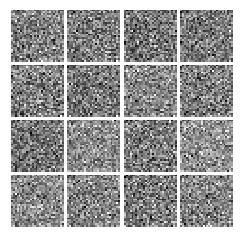


Iter: 0, D: 1.206, G:0.7028
Iter: 50, D: 0.2424, G:1.874
Iter: 100, D: 1.253, G:1.133
Iter: 150, D: 1.708, G:0.9404
Iter: 200, D: 1.506, G:1.253


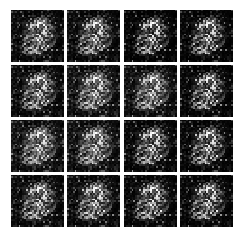


Iter: 250, D: 0.9967, G:1.146
Iter: 300, D: 1.556, G:0.5292
Iter: 350, D: 1.174, G:1.166
Iter: 400, D: 0.8332, G:1.984
Iter: 450, D: 1.473, G:1.046


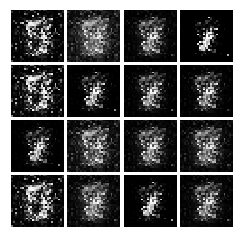


Iter: 500, D: 0.8782, G:0.5745
Iter: 550, D: 1.165, G:1.174
Iter: 600, D: 1.057, G:3.296
Iter: 650, D: 1.134, G:1.279
Iter: 700, D: 1.229, G:1.237


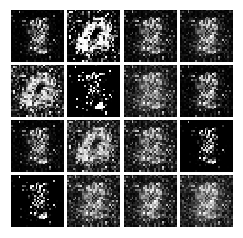


Iter: 750, D: 1.328, G:1.987
Iter: 800, D: 1.369, G:1.076
Iter: 850, D: 1.225, G:0.9117
Iter: 900, D: 1.371, G:1.633
Iter: 950, D: 1.177, G:1.716


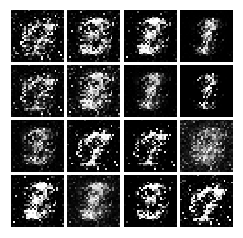


Iter: 1000, D: 1.122, G:1.367
Iter: 1050, D: 1.298, G:1.517
Iter: 1100, D: 1.081, G:1.465
Iter: 1150, D: 1.23, G:0.6824
Iter: 1200, D: 1.352, G:1.483


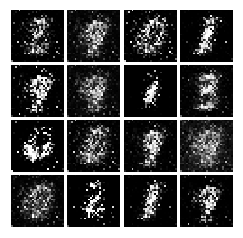


Iter: 1250, D: 1.089, G:1.652
Iter: 1300, D: 1.505, G:0.8322
Iter: 1350, D: 1.152, G:0.9793
Iter: 1400, D: 1.242, G:0.688
Iter: 1450, D: 1.19, G:1.057


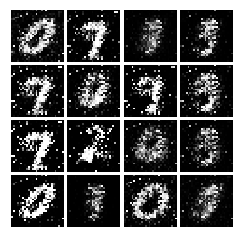


Iter: 1500, D: 1.161, G:1.091
Iter: 1550, D: 1.218, G:0.9077
Iter: 1600, D: 1.262, G:1.107
Iter: 1650, D: 1.367, G:1.163
Iter: 1700, D: 1.184, G:0.9998


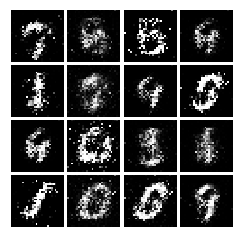


Iter: 1750, D: 1.217, G:0.9401
Iter: 1800, D: 1.411, G:0.6522
Iter: 1850, D: 1.333, G:0.9138
Iter: 1900, D: 1.303, G:0.9017
Iter: 1950, D: 1.368, G:0.7421


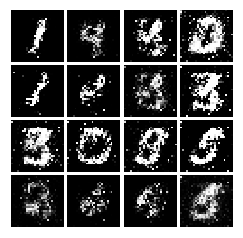


Iter: 2000, D: 1.174, G:1.088
Iter: 2050, D: 1.336, G:0.855
Iter: 2100, D: 1.273, G:0.8946
Iter: 2150, D: 1.213, G:1.144
Iter: 2200, D: 1.227, G:0.9088


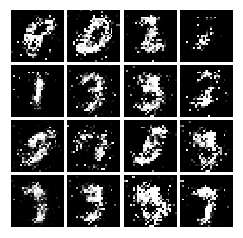


Iter: 2250, D: 1.159, G:2.728
Iter: 2300, D: 1.273, G:0.8169
Iter: 2350, D: 1.213, G:1.012
Iter: 2400, D: 1.209, G:1.013
Iter: 2450, D: 1.222, G:0.9646


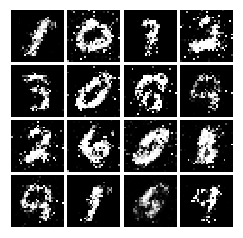


Iter: 2500, D: 1.297, G:0.8938
Iter: 2550, D: 1.291, G:0.8999
Iter: 2600, D: 1.229, G:1.095
Iter: 2650, D: 1.363, G:0.953
Iter: 2700, D: 1.314, G:0.8253


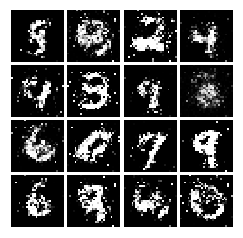


Iter: 2750, D: 1.325, G:0.8724
Iter: 2800, D: 1.266, G:0.8116
Iter: 2850, D: 1.331, G:0.8063
Iter: 2900, D: 1.302, G:0.8469
Iter: 2950, D: 1.27, G:0.8619


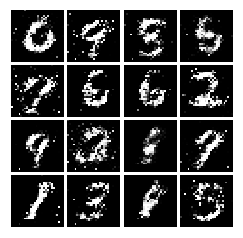


Iter: 3000, D: 1.251, G:0.7326
Iter: 3050, D: 1.403, G:1.016
Iter: 3100, D: 1.303, G:0.7815
Iter: 3150, D: 1.324, G:1.165
Iter: 3200, D: 1.326, G:0.8605


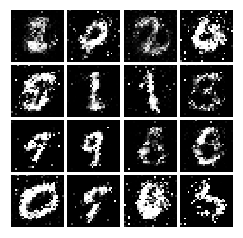


Iter: 3250, D: 1.31, G:0.8278
Iter: 3300, D: 1.348, G:0.7849
Iter: 3350, D: 1.345, G:0.7998
Iter: 3400, D: 1.331, G:0.8803
Iter: 3450, D: 1.313, G:0.8815


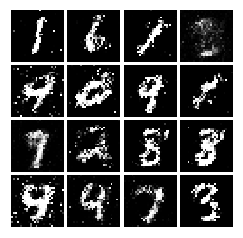


Iter: 3500, D: 1.279, G:0.8499
Iter: 3550, D: 1.364, G:0.9183
Iter: 3600, D: 1.306, G:0.7598
Iter: 3650, D: 1.258, G:0.7345
Iter: 3700, D: 1.366, G:0.618


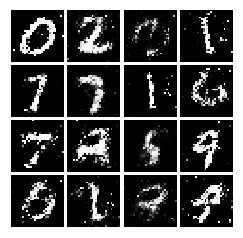


Iter: 3750, D: 1.259, G:1.259
Iter: 3800, D: 1.349, G:0.8267
Iter: 3850, D: 1.33, G:0.8314
Iter: 3900, D: 1.276, G:0.753
Iter: 3950, D: 1.374, G:0.8735


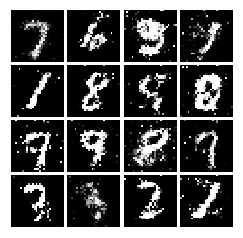


Iter: 4000, D: 1.252, G:0.8376
Iter: 4050, D: 1.361, G:0.7974
Iter: 4100, D: 1.177, G:0.8836
Iter: 4150, D: 1.307, G:0.9194
Iter: 4200, D: 1.305, G:0.8559


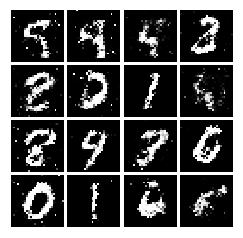


Iter: 4250, D: 1.355, G:0.8758
Final images


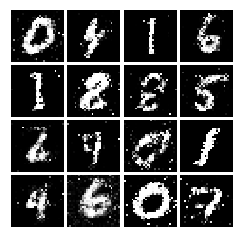

In [68]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step)

# Least Squares GAN
We'll now look at [Least Squares GAN](https://arxiv.org/abs/1611.04076), a newer, more stable alternative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement equation (9) in the paper, with the generator loss:
$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$
and the discriminator loss:
$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$


**HINTS**: Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing. When plugging in for $D(x)$ and $D(G(z))$ use the direct output from the discriminator (`score_real` and `score_fake`).

In [16]:
def lsgan_loss(score_real, score_fake):
    """Compute the Least Squares GAN loss.
    
    Inputs:
    - score_real: Tensor, shape [batch_size, 1], output of discriminator
        score for each real image
    - score_fake: Tensor, shape[batch_size, 1], output of discriminator
        score for each fake image    
          
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    D_loss = 0.5*tf.reduce_mean((score_fake)**2) + 0.5*tf.reduce_mean((score_real-1)**2)
    G_loss = 0.5*tf.reduce_mean((score_fake-1)**2)

    return D_loss, G_loss

Test your LSGAN loss. You should see errors less than 1e-7.

In [17]:
def test_lsgan_loss(score_real, score_fake, d_loss_true, g_loss_true):
    with get_session() as sess:
        d_loss, g_loss = sess.run(
            lsgan_loss(tf.constant(score_real), tf.constant(score_fake)))
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_lsgan_loss(answers['logits_real'], answers['logits_fake'],
                answers['d_loss_lsgan_true'], answers['g_loss_lsgan_true'])

Maximum error in d_loss: 0
Maximum error in g_loss: 0


Create new training steps so we instead minimize the LSGAN loss:

In [18]:
D_loss, G_loss = lsgan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)

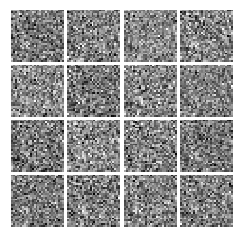


Iter: 0, D: 1.428, G:0.7034
Iter: 50, D: 0.2994, G:1.478
Iter: 100, D: 1.474, G:0.9898
Iter: 150, D: 1.998, G:0.2251
Iter: 200, D: 1.612, G:1.373


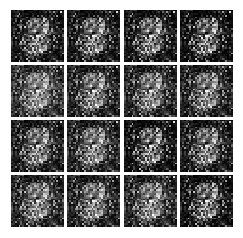


Iter: 250, D: 1.526, G:0.7579
Iter: 300, D: 1.049, G:1.293
Iter: 350, D: 1.291, G:1.184
Iter: 400, D: 1.106, G:0.9152
Iter: 450, D: 1.048, G:1.495


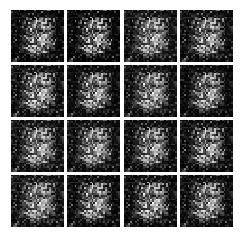


Iter: 500, D: 0.8214, G:1.541
Iter: 550, D: 1.157, G:1.124
Iter: 600, D: 1.1, G:1.18
Iter: 650, D: 1.429, G:0.901
Iter: 700, D: 1.244, G:1.055


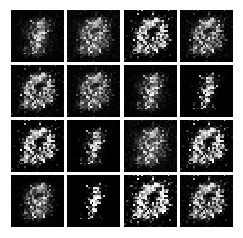


Iter: 750, D: 1.254, G:0.9975
Iter: 800, D: 0.9462, G:1.372
Iter: 850, D: 1.691, G:0.6513
Iter: 900, D: 1.142, G:1.248
Iter: 950, D: 1.575, G:1.074


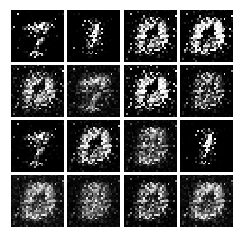


Iter: 1000, D: 1.506, G:0.9135
Iter: 1050, D: 1.078, G:1.396
Iter: 1100, D: 1.143, G:1.342
Iter: 1150, D: 1.208, G:1.275
Iter: 1200, D: 1.266, G:0.9647


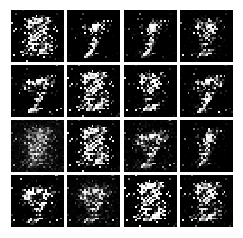


Iter: 1250, D: 0.9506, G:1.448
Iter: 1300, D: 1.31, G:1.036
Iter: 1350, D: 1.439, G:0.927
Iter: 1400, D: 1.359, G:1.033
Iter: 1450, D: 1.352, G:0.8406


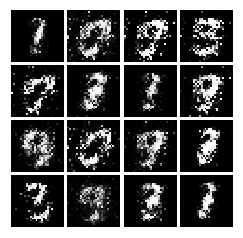


Iter: 1500, D: 1.385, G:1.017
Iter: 1550, D: 1.235, G:0.9969
Iter: 1600, D: 1.212, G:0.9372
Iter: 1650, D: 1.148, G:1.008
Iter: 1700, D: 1.198, G:0.9518


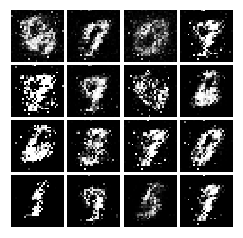


Iter: 1750, D: 1.168, G:1.162
Iter: 1800, D: 1.32, G:0.8709
Iter: 1850, D: 1.257, G:0.8725
Iter: 1900, D: 1.221, G:0.8915
Iter: 1950, D: 1.179, G:0.9012


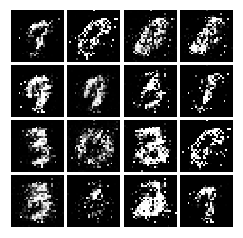


Iter: 2000, D: 1.239, G:0.8593
Iter: 2050, D: 1.335, G:1.056
Iter: 2100, D: 1.07, G:0.7976
Iter: 2150, D: 1.253, G:0.9866
Iter: 2200, D: 1.293, G:0.8088


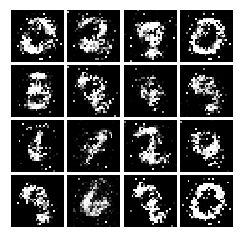


Iter: 2250, D: 1.297, G:0.9027
Iter: 2300, D: 1.359, G:0.8559
Iter: 2350, D: 1.279, G:0.9467
Iter: 2400, D: 1.284, G:0.9304
Iter: 2450, D: 1.186, G:1.102


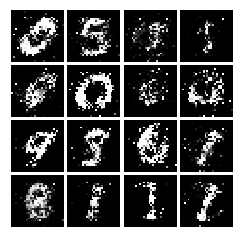


Iter: 2500, D: 1.294, G:1.054
Iter: 2550, D: 1.416, G:1.577
Iter: 2600, D: 1.246, G:1.046
Iter: 2650, D: 1.249, G:1.212
Iter: 2700, D: 1.509, G:0.6769


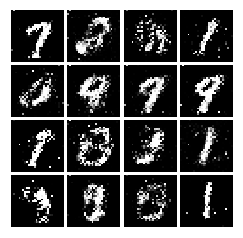


Iter: 2750, D: 1.251, G:1.023
Iter: 2800, D: 1.283, G:0.832
Iter: 2850, D: 1.619, G:0.8889
Iter: 2900, D: 1.385, G:0.7688
Iter: 2950, D: 1.336, G:0.7779


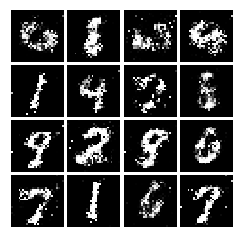


Iter: 3000, D: 1.392, G:0.8463
Iter: 3050, D: 1.336, G:0.7862
Iter: 3100, D: 1.392, G:0.8129
Iter: 3150, D: 1.301, G:0.9157
Iter: 3200, D: 1.322, G:0.754


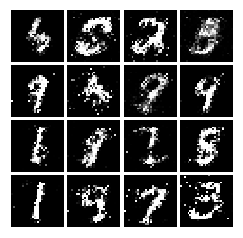


Iter: 3250, D: 1.307, G:0.8121
Iter: 3300, D: 1.324, G:0.7809
Iter: 3350, D: 1.275, G:0.8924
Iter: 3400, D: 1.268, G:0.8025
Iter: 3450, D: 1.307, G:0.8587


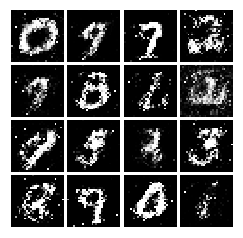


Iter: 3500, D: 1.19, G:1.03
Iter: 3550, D: 1.365, G:0.8621
Iter: 3600, D: 1.352, G:0.8485
Iter: 3650, D: 1.287, G:0.7821
Iter: 3700, D: 1.335, G:0.7922


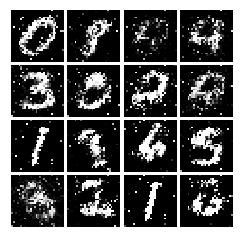


Iter: 3750, D: 1.38, G:0.9904
Iter: 3800, D: 1.349, G:0.7733
Iter: 3850, D: 1.342, G:0.8242
Iter: 3900, D: 1.339, G:0.8233
Iter: 3950, D: 1.292, G:0.8002


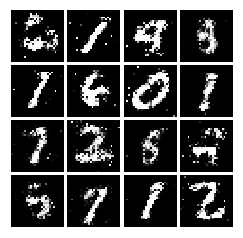


Iter: 4000, D: 1.366, G:0.7651
Iter: 4050, D: 1.389, G:0.9873
Iter: 4100, D: 1.381, G:0.8643
Iter: 4150, D: 1.342, G:0.7704
Iter: 4200, D: 1.326, G:0.7992


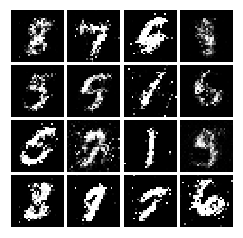


Iter: 4250, D: 1.349, G:0.9065
Final images


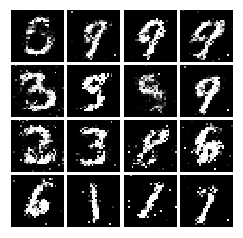

In [78]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step)

# INLINE QUESTION 1:
Describe how the visual quality of the samples changes over the course of training. Do you notice anything about the distribution of the samples? How do the results change across different training runs?

** (Write Your Answer In This Cell) **

# Deep Convolutional GANs
In the first part of the notebook, we implemented an almost direct copy of the original GAN network from Ian Goodfellow. However, this network architecture allows no real spatial reasoning. It is unable to reason about things like "sharp edges" in general because it lacks any convolutional layers. Thus, in this section, we will implement some of the ideas from [DCGAN](https://arxiv.org/abs/1511.06434), where we use convolutional networks as our discriminators and generators.

#### Discriminator
We will use a discriminator inspired by the TensorFlow MNIST classification [tutorial](https://www.tensorflow.org/get_started/mnist/pros), which is able to get above 99% accuracy on the MNIST dataset fairly quickly. *Be sure to check the dimensions of x and reshape when needed*, fully connected blocks expect [N,D] Tensors while conv2d blocks expect [N,H,W,C] Tensors. 

Architecture:
* 32 Filters, 5x5, Stride 1, Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* 64 Filters, 5x5, Stride 1, Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Flatten
* Fully Connected size 4 x 4 x 64, Leaky ReLU(alpha=0.01)
* Fully Connected size 1

In [19]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    
    leaky_relu = lambda x: tf.nn.leaky_relu(x, 0.01)
    
    with tf.variable_scope("discriminator"):
        h = x
        h = tf.reshape(h, (-1, 28, 28, 1))
        h = tf.layers.conv2d(h, 32, (5,5), activation=leaky_relu)
        h = tf.layers.max_pooling2d(h, (2,2), (2,2))
        h = tf.layers.conv2d(h, 64, (5,5), activation=leaky_relu)
        h = tf.layers.max_pooling2d(h, (2,2), (2,2))
        h = tf.layers.flatten(h)
        h = tf.layers.dense(h, 4*4*64, activation=leaky_relu)
        h = tf.layers.dense(h, 1)
        logits = h
    
        return logits
test_discriminator(1102721)

Correct number of parameters in discriminator.


#### Generator
For the generator, we will copy the architecture exactly from the [InfoGAN paper](https://arxiv.org/pdf/1606.03657.pdf). See Appendix C.1 MNIST. See the documentation for [tf.nn.conv2d_transpose](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). We are always "training" in GAN mode.

Architecture:
* Fully connected of size 1024, ReLU
* BatchNorm
* Fully connected of size 7 x 7 x 128, ReLU
* BatchNorm
* Resize into Image Tensor
* 64 conv2d^T (transpose) filters of 4x4, stride 2, ReLU
* BatchNorm
* 1 conv2d^T (transpose) filter of 4x4, stride 2, TanH

In [20]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        h = z
        h = tf.layers.dense(h, 1024, activation=tf.nn.relu)
        h = tf.layers.batch_normalization(h, training=True)
        h = tf.layers.dense(h, 7*7*128, activation=tf.nn.relu)
        h = tf.layers.batch_normalization(h, training=True)
        h = tf.reshape(h, (-1, 7, 7, 128))
        h = tf.layers.conv2d_transpose(h, 64, (4,4), strides=(2,2), padding='same',  activation=tf.nn.relu)
        h = tf.layers.batch_normalization(h, training=True)
        h = tf.layers.conv2d_transpose(h, 1, (4,4), strides=(2,2), padding='same', activation=tf.tanh)
        h = tf.reshape(h, (-1, 28*28))
        img = h
        return img
test_generator(6595521)

Correct number of parameters in generator.


We have to recreate our network since we've changed our functions.

In [21]:
tf.reset_default_graph()

batch_size = 128
# our noise dimension
noise_dim = 96

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator') 

D_solver,G_solver = get_solvers()
D_loss, G_loss = gan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')

### Train and evaluate a DCGAN
This is the one part of A3 that significantly benefits from using a GPU. It takes 3 minutes on a GPU for the requested five epochs. Or about 50 minutes on a dual core laptop on CPU (feel free to use 3 epochs if you do it on CPU).

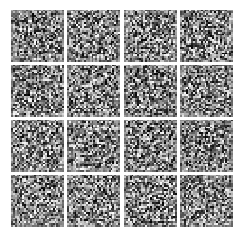


Iter: 0, D: 1.355, G:0.9652
Iter: 50, D: 2.173, G:0.3353
Iter: 100, D: 1.131, G:0.7668
Iter: 150, D: 1.223, G:3.21
Iter: 200, D: 0.904, G:1.321


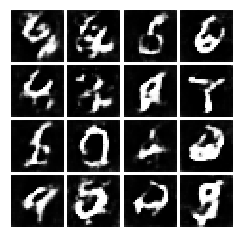


Iter: 250, D: 1.062, G:0.8261
Iter: 300, D: 1.075, G:1.018
Iter: 350, D: 1.097, G:1.061
Iter: 400, D: 1.071, G:0.895
Iter: 450, D: 1.184, G:1.161


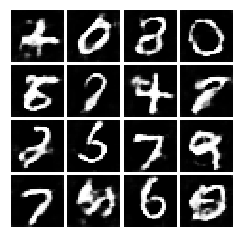


Iter: 500, D: 1.15, G:1.032
Iter: 550, D: 1.138, G:0.8574
Iter: 600, D: 1.224, G:0.906
Iter: 650, D: 1.206, G:0.5715
Iter: 700, D: 1.164, G:0.8288


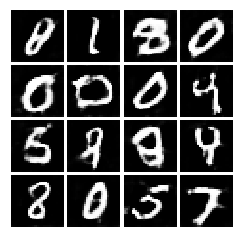


Iter: 750, D: 1.145, G:0.9754
Iter: 800, D: 1.319, G:0.7367
Iter: 850, D: 1.137, G:0.7884
Iter: 900, D: 1.164, G:1.027
Iter: 950, D: 1.175, G:0.6957


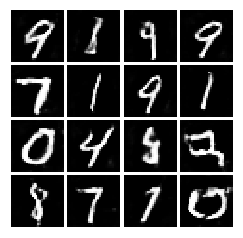


Iter: 1000, D: 1.194, G:0.8425
Iter: 1050, D: 1.249, G:1.267
Iter: 1100, D: 1.245, G:0.5986
Iter: 1150, D: 1.207, G:1.023
Iter: 1200, D: 1.228, G:1.102


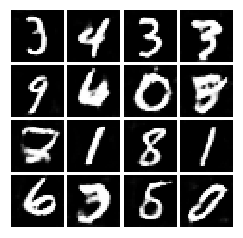


Iter: 1250, D: 1.145, G:0.9467
Iter: 1300, D: 1.073, G:1.2
Iter: 1350, D: 1.187, G:1.007
Iter: 1400, D: 1.209, G:0.9051
Iter: 1450, D: 1.152, G:1.341


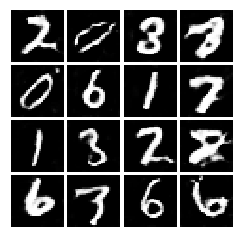


Iter: 1500, D: 1.188, G:1.186
Iter: 1550, D: 1.127, G:0.98
Iter: 1600, D: 1.153, G:1.004
Iter: 1650, D: 1.451, G:0.8159
Iter: 1700, D: 1.078, G:0.9728


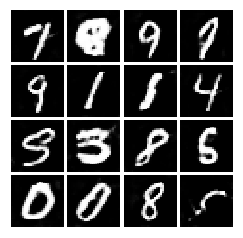


Iter: 1750, D: 1.613, G:0.9546
Iter: 1800, D: 1.21, G:1.495
Iter: 1850, D: 1.273, G:0.8976
Iter: 1900, D: 1.106, G:1.042
Iter: 1950, D: 1.082, G:0.9914


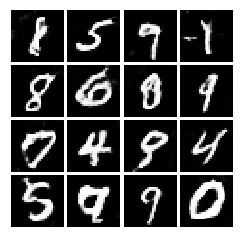


Iter: 2000, D: 1.226, G:0.7706
Iter: 2050, D: 1.125, G:1.032
Iter: 2100, D: 1.139, G:1.281
Final images


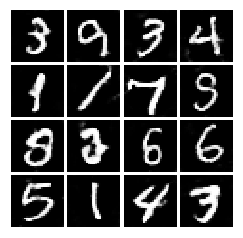

In [98]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step,num_epoch=5)

# INLINE QUESTION 2:
What differences do you see between the DCGAN results and the original GAN results?

** (Write Your Answer In This Cell) **

------

# Extra Credit 
** Be sure you don't destroy your results above, but feel free to copy+paste code to get results below **
* For a small amount of extra credit, you can implement additional new GAN loss functions below, provided they converge. See AFI, BiGAN, Softmax GAN, Conditional GAN, InfoGAN, etc. They should converge to get credit.
* Likewise for an improved architecture or using a convolutional GAN (or even implement a VAE)
* For a bigger chunk of extra credit, load the CIFAR10 data (see last assignment) and train a compelling generative model on CIFAR-10
* Demonstrate the value of GANs in building semi-supervised models. In a semi-supervised example, only some fraction of the input data has labels; we can supervise this in MNIST by only training on a few dozen or hundred labeled examples. This was first described in [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498).
* Something new/cool.

#### Describe what you did here

# Fashion MNIST GAN
This code probably could be much cleaner, but I'm no TensorFlow pro...

In [222]:
import itertools

# a giant helper function
def custom_gan(sess, G_train_step, G_loss, D_train_step, D_loss,\
              show_every=250, print_every=50):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    Returns:
        Nothing
    """
    for it in itertools.count():
        if it % show_every == 0:
            samples = sess.run(G_sample)
            fig = show_images(samples[:16])
            plt.show()
            print()
        try:
            _, D_loss_curr = sess.run([D_train_step, D_loss])
            _, G_loss_curr = sess.run([G_train_step, G_loss])
            if it % print_every == 0:
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(it,D_loss_curr,G_loss_curr))
        except tf.errors.OutOfRangeError:
            break
            
    print('Final images')
    samples = sess.run(G_sample)
    fig = show_images(samples[:16])
    plt.show()


def load_fashion(train_data_path, train_labels_path):  
    x_raw = np.load(train_data_path).astype(np.float32) / 255.0
    y_raw = np.load(train_labels_path).astype(np.float32)
    return tf.data.Dataset.from_tensor_slices((x_raw, y_raw))

In [238]:
tf.reset_default_graph()
fashion_data = load_fashion("cs231n/datasets/fashion/Fashion-MNIST-data-train.npy",
                            "cs231n/datasets/fashion/Fashion-MNIST-labels-train.npy")

In [239]:
batch_size = 128
num_epoch = 40


# our noise dimension
noise_dim = 96

# placeholders for images from the training dataset
fashion_data = fashion_data.repeat(num_epoch)
fashion_data = fashion_data.batch(batch_size)
iterator = fashion_data.make_initializable_iterator()

x, _ = iterator.get_next()
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator') 

D_solver,G_solver = get_solvers()
D_loss, G_loss = gan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)


In [240]:
sess = tf.InteractiveSession()

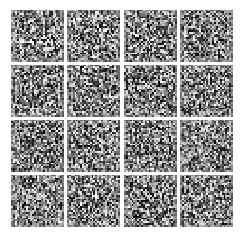


Iter: 0, D: 1.381, G:0.8804
Iter: 50, D: 1.133, G:0.8113
Iter: 100, D: 0.9807, G:1.231
Iter: 150, D: 1.026, G:1.166
Iter: 200, D: 1.219, G:0.8442
Iter: 250, D: 0.9259, G:1.197
Iter: 300, D: 1.02, G:1.196
Iter: 350, D: 1.178, G:0.8839
Iter: 400, D: 1.112, G:1.273
Iter: 450, D: 1.314, G:0.8329
Iter: 500, D: 1.127, G:1.042
Iter: 550, D: 1.06, G:0.9456
Iter: 600, D: 1.19, G:1.175
Iter: 650, D: 1.139, G:1.044
Iter: 700, D: 1.149, G:0.9433
Iter: 750, D: 1.19, G:0.9835
Iter: 800, D: 1.227, G:0.8315
Iter: 850, D: 1.225, G:0.9022
Iter: 900, D: 1.18, G:1.039
Iter: 950, D: 1.213, G:1.0


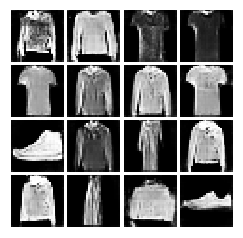


Iter: 1000, D: 1.153, G:0.9721
Iter: 1050, D: 1.164, G:0.853
Iter: 1100, D: 1.225, G:0.8057
Iter: 1150, D: 1.152, G:1.001
Iter: 1200, D: 1.193, G:0.9048
Iter: 1250, D: 1.177, G:0.9778
Iter: 1300, D: 1.155, G:1.267
Iter: 1350, D: 1.213, G:1.078
Iter: 1400, D: 1.122, G:0.7796
Iter: 1450, D: 1.127, G:0.9752
Iter: 1500, D: 1.153, G:1.051
Iter: 1550, D: 1.161, G:0.8985
Iter: 1600, D: 1.217, G:1.053
Iter: 1650, D: 1.188, G:0.8647
Iter: 1700, D: 1.215, G:0.7385
Iter: 1750, D: 1.217, G:1.095
Iter: 1800, D: 1.047, G:1.525
Iter: 1850, D: 1.108, G:1.203
Iter: 1900, D: 1.157, G:1.011
Iter: 1950, D: 1.17, G:1.225


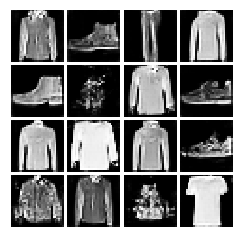


Iter: 2000, D: 1.099, G:1.083
Iter: 2050, D: 1.115, G:0.9349
Iter: 2100, D: 1.077, G:1.104
Iter: 2150, D: 1.124, G:1.191
Iter: 2200, D: 1.085, G:1.223
Iter: 2250, D: 1.057, G:0.9825
Iter: 2300, D: 1.078, G:1.115
Iter: 2350, D: 1.082, G:1.274
Iter: 2400, D: 1.08, G:1.032
Iter: 2450, D: 1.087, G:0.9494
Iter: 2500, D: 1.085, G:1.116
Iter: 2550, D: 1.001, G:1.031
Iter: 2600, D: 1.218, G:1.151
Iter: 2650, D: 0.9647, G:1.358
Iter: 2700, D: 1.126, G:1.43
Iter: 2750, D: 0.9875, G:1.396
Iter: 2800, D: 1.015, G:1.503
Iter: 2850, D: 1.042, G:1.159
Iter: 2900, D: 0.9663, G:1.228
Iter: 2950, D: 0.9492, G:1.183


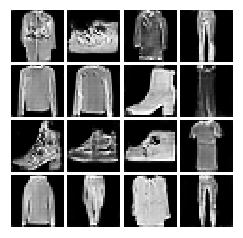


Iter: 3000, D: 0.8601, G:1.139
Iter: 3050, D: 0.9575, G:1.116
Iter: 3100, D: 0.9703, G:1.166
Iter: 3150, D: 0.89, G:1.139
Iter: 3200, D: 0.9396, G:1.192
Iter: 3250, D: 0.9661, G:1.507
Iter: 3300, D: 1.05, G:1.129
Iter: 3350, D: 0.9728, G:1.32
Iter: 3400, D: 1.006, G:1.403
Iter: 3450, D: 0.8942, G:1.659
Iter: 3500, D: 0.9865, G:1.124
Iter: 3550, D: 1.088, G:1.259
Iter: 3600, D: 0.9862, G:1.336
Iter: 3650, D: 0.9239, G:1.333
Iter: 3700, D: 0.9077, G:1.537
Iter: 3750, D: 0.9217, G:1.449
Iter: 3800, D: 0.8935, G:1.579
Iter: 3850, D: 0.9548, G:1.112
Iter: 3900, D: 1.037, G:1.271
Iter: 3950, D: 0.9729, G:1.372


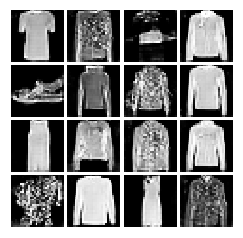


Iter: 4000, D: 0.9054, G:1.315
Iter: 4050, D: 0.8524, G:1.489
Iter: 4100, D: 1.051, G:1.985
Iter: 4150, D: 0.8513, G:1.455
Iter: 4200, D: 0.8186, G:1.613
Iter: 4250, D: 0.8387, G:1.646
Iter: 4300, D: 0.7917, G:1.248
Iter: 4350, D: 0.8554, G:1.463
Iter: 4400, D: 0.9142, G:1.296
Iter: 4450, D: 0.829, G:1.483
Iter: 4500, D: 0.8165, G:1.239
Iter: 4550, D: 0.8707, G:1.333
Iter: 4600, D: 0.9212, G:1.51
Iter: 4650, D: 0.9167, G:1.169
Iter: 4700, D: 0.8374, G:1.44
Iter: 4750, D: 0.8447, G:1.493
Iter: 4800, D: 0.7708, G:1.592
Iter: 4850, D: 0.8248, G:1.618
Iter: 4900, D: 0.6977, G:1.535
Iter: 4950, D: 0.8438, G:1.229


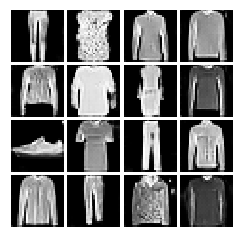


Iter: 5000, D: 0.8731, G:1.871
Iter: 5050, D: 0.7675, G:1.964
Iter: 5100, D: 0.9874, G:1.637
Iter: 5150, D: 0.7411, G:1.307
Iter: 5200, D: 0.8021, G:1.764
Iter: 5250, D: 0.7079, G:1.569
Iter: 5300, D: 0.769, G:1.498
Iter: 5350, D: 0.7147, G:1.609
Iter: 5400, D: 0.7633, G:1.726
Iter: 5450, D: 0.7878, G:1.576
Iter: 5500, D: 0.7907, G:1.442
Iter: 5550, D: 0.7202, G:1.891
Iter: 5600, D: 0.7177, G:1.788
Iter: 5650, D: 0.7422, G:1.595
Iter: 5700, D: 0.7409, G:1.774
Iter: 5750, D: 0.7231, G:2.134
Iter: 5800, D: 0.7758, G:2.07
Iter: 5850, D: 0.7765, G:1.438
Iter: 5900, D: 0.7225, G:1.323
Iter: 5950, D: 0.7472, G:1.838


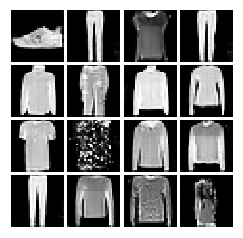


Iter: 6000, D: 0.6999, G:2.103
Iter: 6050, D: 0.7211, G:1.769
Iter: 6100, D: 0.6962, G:1.782
Iter: 6150, D: 0.6413, G:1.758
Iter: 6200, D: 0.6741, G:1.978
Iter: 6250, D: 0.7986, G:1.902
Iter: 6300, D: 0.713, G:2.332
Iter: 6350, D: 0.9491, G:1.289
Iter: 6400, D: 0.7437, G:1.753
Iter: 6450, D: 0.881, G:1.598
Iter: 6500, D: 0.4896, G:2.324
Iter: 6550, D: 0.6458, G:1.796
Iter: 6600, D: 0.7525, G:1.684
Iter: 6650, D: 0.6388, G:1.717
Iter: 6700, D: 0.6901, G:2.372
Iter: 6750, D: 0.6671, G:2.186
Iter: 6800, D: 0.5427, G:2.263
Iter: 6850, D: 0.733, G:1.788
Iter: 6900, D: 0.8977, G:2.692
Iter: 6950, D: 0.6723, G:2.396


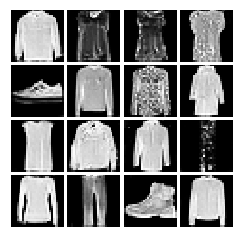


Iter: 7000, D: 0.7164, G:1.706
Iter: 7050, D: 0.7713, G:2.0
Iter: 7100, D: 0.6393, G:2.066
Iter: 7150, D: 0.5652, G:1.941
Iter: 7200, D: 0.5429, G:2.414
Iter: 7250, D: 0.6774, G:2.009
Iter: 7300, D: 0.7205, G:2.016
Iter: 7350, D: 0.6131, G:1.562
Iter: 7400, D: 0.7357, G:2.267
Iter: 7450, D: 0.6281, G:1.81
Iter: 7500, D: 0.6014, G:2.238
Iter: 7550, D: 0.6803, G:2.563
Iter: 7600, D: 0.6123, G:2.368
Iter: 7650, D: 0.6122, G:1.931
Iter: 7700, D: 0.6716, G:2.073
Iter: 7750, D: 0.5262, G:2.16
Iter: 7800, D: 0.5895, G:2.819
Iter: 7850, D: 0.6312, G:2.2
Iter: 7900, D: 0.544, G:2.413
Iter: 7950, D: 0.619, G:2.12


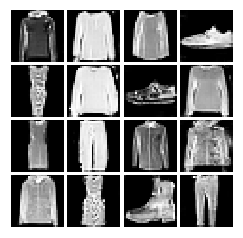


Iter: 8000, D: 0.5189, G:2.007
Iter: 8050, D: 0.577, G:2.05
Iter: 8100, D: 0.5765, G:2.359
Iter: 8150, D: 0.5131, G:2.086
Iter: 8200, D: 0.426, G:2.574
Iter: 8250, D: 0.6278, G:2.199
Iter: 8300, D: 0.5388, G:1.845
Iter: 8350, D: 0.5507, G:1.689
Iter: 8400, D: 0.7097, G:2.805
Iter: 8450, D: 0.654, G:1.999
Iter: 8500, D: 0.5016, G:2.365
Iter: 8550, D: 0.6022, G:2.185
Iter: 8600, D: 0.6047, G:2.194
Iter: 8650, D: 0.5361, G:2.135
Iter: 8700, D: 0.5715, G:2.487
Iter: 8750, D: 0.6402, G:2.501
Iter: 8800, D: 0.4505, G:2.287
Iter: 8850, D: 0.5521, G:2.43
Iter: 8900, D: 0.4691, G:2.177
Iter: 8950, D: 0.4889, G:2.324


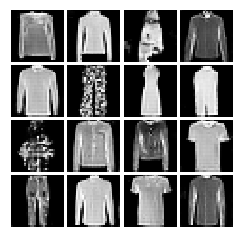


Iter: 9000, D: 0.4753, G:2.322
Iter: 9050, D: 0.5839, G:1.994
Iter: 9100, D: 0.5369, G:2.687
Iter: 9150, D: 0.5927, G:2.688
Iter: 9200, D: 0.4656, G:2.246
Iter: 9250, D: 0.4065, G:2.852
Iter: 9300, D: 0.5566, G:2.52
Iter: 9350, D: 0.4684, G:2.702
Iter: 9400, D: 0.5064, G:2.458
Iter: 9450, D: 0.4449, G:2.751
Iter: 9500, D: 0.4887, G:2.61
Iter: 9550, D: 0.5387, G:3.012
Iter: 9600, D: 0.5577, G:2.296
Iter: 9650, D: 0.44, G:2.475
Iter: 9700, D: 0.4884, G:2.891
Iter: 9750, D: 0.469, G:2.672
Iter: 9800, D: 0.3975, G:2.771
Iter: 9850, D: 0.4273, G:2.895
Iter: 9900, D: 0.3793, G:3.287
Iter: 9950, D: 0.3811, G:2.414


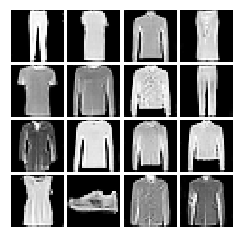


Iter: 10000, D: 0.4592, G:2.783
Iter: 10050, D: 0.342, G:2.464
Iter: 10100, D: 0.4962, G:2.498
Iter: 10150, D: 0.4351, G:2.983
Iter: 10200, D: 0.3981, G:2.912
Iter: 10250, D: 0.4255, G:2.983
Iter: 10300, D: 0.3781, G:3.144
Iter: 10350, D: 0.5451, G:3.223
Iter: 10400, D: 0.4596, G:3.218
Iter: 10450, D: 0.3992, G:3.072
Iter: 10500, D: 0.3453, G:2.923
Iter: 10550, D: 0.4913, G:3.193
Iter: 10600, D: 0.5007, G:2.703
Iter: 10650, D: 0.4366, G:3.376
Iter: 10700, D: 0.4769, G:3.272
Iter: 10750, D: 0.3921, G:3.14
Iter: 10800, D: 0.4442, G:2.307
Iter: 10850, D: 0.5204, G:3.1
Iter: 10900, D: 0.6254, G:2.662
Iter: 10950, D: 0.3306, G:3.324


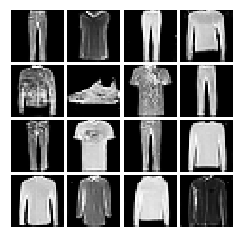


Iter: 11000, D: 0.4237, G:3.207
Iter: 11050, D: 0.4676, G:2.806
Iter: 11100, D: 0.4077, G:3.024
Iter: 11150, D: 0.3681, G:3.303
Iter: 11200, D: 0.3395, G:2.807
Iter: 11250, D: 0.4925, G:2.817
Iter: 11300, D: 0.4312, G:2.762
Iter: 11350, D: 0.3596, G:3.04
Iter: 11400, D: 0.4066, G:2.452
Iter: 11450, D: 0.4111, G:3.051
Iter: 11500, D: 0.3708, G:3.028
Iter: 11550, D: 0.352, G:3.604
Iter: 11600, D: 0.3904, G:3.979
Iter: 11650, D: 0.415, G:3.076
Iter: 11700, D: 0.3086, G:2.977
Iter: 11750, D: 0.3913, G:3.264
Iter: 11800, D: 0.3959, G:3.628
Iter: 11850, D: 0.4062, G:2.799
Iter: 11900, D: 0.3338, G:2.869
Iter: 11950, D: 0.3551, G:3.418


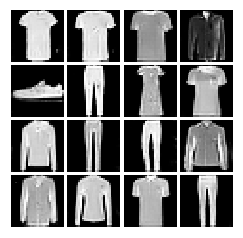


Iter: 12000, D: 0.3698, G:3.09
Iter: 12050, D: 0.5319, G:2.778
Iter: 12100, D: 0.3156, G:2.914
Iter: 12150, D: 0.3556, G:3.555
Iter: 12200, D: 0.437, G:2.896
Iter: 12250, D: 0.496, G:3.58
Iter: 12300, D: 0.3265, G:3.047
Iter: 12350, D: 0.369, G:3.271
Iter: 12400, D: 0.4265, G:4.115
Iter: 12450, D: 0.333, G:3.529
Iter: 12500, D: 0.4008, G:2.81
Iter: 12550, D: 0.4261, G:3.625
Iter: 12600, D: 0.4092, G:2.655
Iter: 12650, D: 0.3951, G:3.739
Iter: 12700, D: 0.4328, G:3.832
Iter: 12750, D: 0.4776, G:3.7
Iter: 12800, D: 0.3816, G:3.141
Iter: 12850, D: 0.2219, G:4.126
Iter: 12900, D: 0.3315, G:2.756
Iter: 12950, D: 0.3533, G:2.759


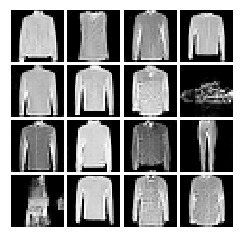


Iter: 13000, D: 0.2512, G:3.857
Iter: 13050, D: 0.2274, G:4.115
Iter: 13100, D: 0.3889, G:4.04
Iter: 13150, D: 0.5416, G:3.654
Iter: 13200, D: 0.2378, G:3.667
Iter: 13250, D: 0.3288, G:3.197
Iter: 13300, D: 0.2876, G:4.085
Iter: 13350, D: 0.4461, G:3.699
Iter: 13400, D: 0.3957, G:3.377
Iter: 13450, D: 0.306, G:3.742
Iter: 13500, D: 23.77, G:4.822
Iter: 13550, D: 0.7867, G:1.625
Iter: 13600, D: 0.6379, G:1.891
Iter: 13650, D: 0.4949, G:2.363
Iter: 13700, D: 0.5193, G:2.694
Iter: 13750, D: 0.4721, G:3.652
Iter: 13800, D: 0.333, G:3.583
Iter: 13850, D: 0.421, G:3.095
Iter: 13900, D: 0.3561, G:3.036
Iter: 13950, D: 0.3642, G:3.105


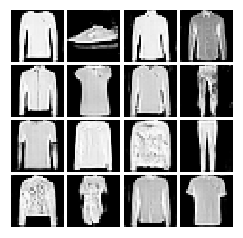


Iter: 14000, D: 0.2936, G:3.382
Iter: 14050, D: 0.3342, G:2.902
Iter: 14100, D: 0.4177, G:3.419
Iter: 14150, D: 0.313, G:2.933
Iter: 14200, D: 0.2709, G:3.85
Iter: 14250, D: 0.3911, G:4.058
Iter: 14300, D: 0.239, G:3.618
Iter: 14350, D: 0.3327, G:4.001
Iter: 14400, D: 0.3042, G:4.239
Iter: 14450, D: 0.3796, G:4.45
Iter: 14500, D: 0.2872, G:3.438
Iter: 14550, D: 0.3222, G:3.817
Iter: 14600, D: 0.3514, G:3.955
Iter: 14650, D: 0.3713, G:3.593
Iter: 14700, D: 0.2081, G:4.09
Iter: 14750, D: 0.2745, G:3.387
Iter: 14800, D: 0.3004, G:3.316
Iter: 14850, D: 0.2954, G:4.038
Iter: 14900, D: 0.3239, G:4.091
Iter: 14950, D: 0.2793, G:3.392


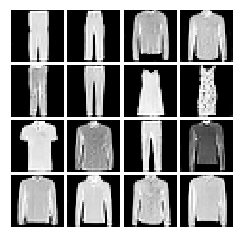


Iter: 15000, D: 0.3234, G:3.743
Iter: 15050, D: 0.3607, G:3.74
Iter: 15100, D: 0.3873, G:4.19
Iter: 15150, D: 0.3341, G:3.05
Iter: 15200, D: 0.2836, G:3.605
Iter: 15250, D: 0.2574, G:4.023
Iter: 15300, D: 0.1637, G:3.935
Iter: 15350, D: 0.3305, G:4.312
Iter: 15400, D: 0.3143, G:4.497
Iter: 15450, D: 0.242, G:4.192
Iter: 15500, D: 0.2367, G:4.011
Iter: 15550, D: 0.273, G:4.161
Iter: 15600, D: 0.2592, G:3.444
Iter: 15650, D: 0.2369, G:3.995
Iter: 15700, D: 0.2195, G:3.608
Iter: 15750, D: 0.2412, G:4.164
Iter: 15800, D: 0.3022, G:4.452
Iter: 15850, D: 0.23, G:3.342
Iter: 15900, D: 0.3607, G:4.465
Iter: 15950, D: 0.245, G:3.985


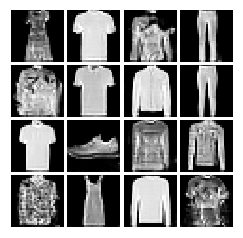


Iter: 16000, D: 0.2479, G:4.547
Iter: 16050, D: 0.2468, G:4.096
Iter: 16100, D: 0.261, G:4.383
Iter: 16150, D: 0.1964, G:4.263
Iter: 16200, D: 0.216, G:4.916
Iter: 16250, D: 0.4098, G:3.361
Iter: 16300, D: 0.3002, G:4.214
Iter: 16350, D: 0.3706, G:4.291
Iter: 16400, D: 0.3041, G:3.863
Iter: 16450, D: 0.2718, G:4.023
Iter: 16500, D: 0.259, G:3.769
Iter: 16550, D: 0.1827, G:4.521
Iter: 16600, D: 0.1889, G:4.539
Iter: 16650, D: 0.2877, G:3.366
Iter: 16700, D: 0.2079, G:4.395
Iter: 16750, D: 0.1978, G:5.129
Iter: 16800, D: 0.1357, G:4.248
Iter: 16850, D: 0.1959, G:4.457
Iter: 16900, D: 0.2202, G:4.214
Iter: 16950, D: 0.1656, G:3.893


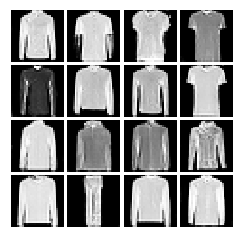


Iter: 17000, D: 0.1959, G:4.021
Iter: 17050, D: 0.1555, G:4.739
Iter: 17100, D: 0.2667, G:3.838
Iter: 17150, D: 0.1815, G:4.264
Iter: 17200, D: 0.2588, G:4.257
Iter: 17250, D: 0.2823, G:3.885
Iter: 17300, D: 0.1793, G:4.468
Iter: 17350, D: 0.3475, G:4.478
Iter: 17400, D: 0.2562, G:4.41
Iter: 17450, D: 0.2427, G:4.151
Iter: 17500, D: 0.2302, G:4.592
Iter: 17550, D: 0.1656, G:4.775
Iter: 17600, D: 0.2261, G:4.025
Iter: 17650, D: 0.2567, G:3.52
Iter: 17700, D: 0.201, G:5.051
Iter: 17750, D: 0.2758, G:4.359
Iter: 17800, D: 0.2405, G:4.257
Iter: 17850, D: 0.2967, G:4.077
Iter: 17900, D: 0.2939, G:3.63
Iter: 17950, D: 0.1481, G:4.958


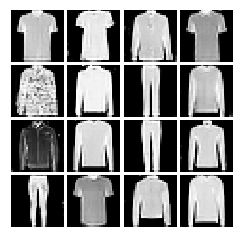


Iter: 18000, D: 0.1688, G:4.03
Iter: 18050, D: 0.1858, G:4.753
Iter: 18100, D: 0.2352, G:4.159
Iter: 18150, D: 0.3035, G:4.775
Iter: 18200, D: 0.2669, G:4.494
Iter: 18250, D: 0.3506, G:4.448
Iter: 18300, D: 0.1969, G:4.053
Iter: 18350, D: 0.1201, G:4.404
Iter: 18400, D: 0.1837, G:4.231
Iter: 18450, D: 0.1653, G:4.693
Iter: 18500, D: 0.2413, G:4.939
Iter: 18550, D: 0.2187, G:3.877
Iter: 18600, D: 0.09352, G:5.202
Iter: 18650, D: 0.1628, G:4.828
Iter: 18700, D: 0.2077, G:4.733
Final images


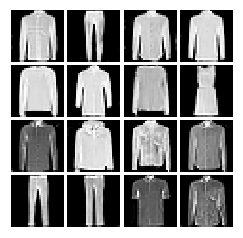

In [241]:
init_op = tf.global_variables_initializer()
# with get_session() as sess:
sess.run(init_op)
sess.run(iterator.initializer)
custom_gan(sess,G_train_step,G_loss,D_train_step, D_loss, show_every=1000)

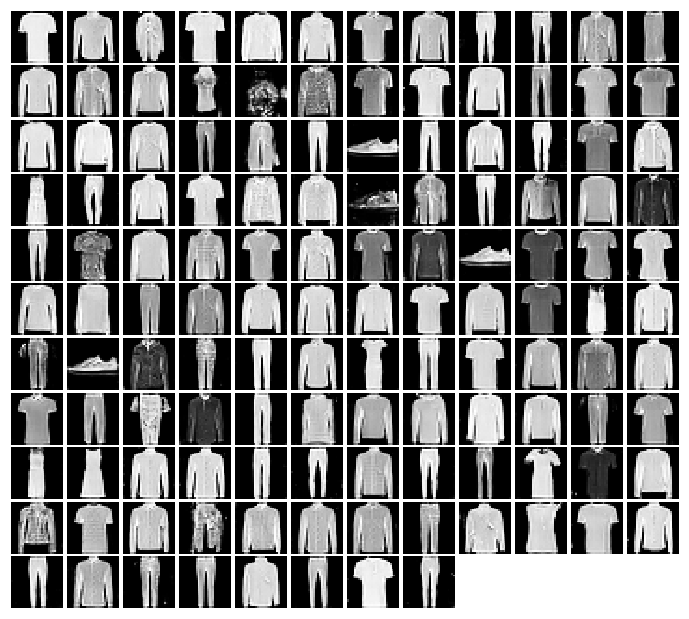

In [245]:
samples = sess.run(G_sample)
fig = show_images(samples[:128])
plt.show()

# Conditional MNIST GAN

In [43]:
def generator(z, y):

    with tf.variable_scope("generator"):
        hz = tf.layers.dense(z, 768)
        hy = tf.layers.dense(y, 768)
        h = tf.concat((hz,hy), 1)
        h = tf.nn.relu(h)
        h = tf.layers.batch_normalization(h, training=True)
        h = tf.layers.dense(h, 7*7*128, activation=tf.nn.relu)
        h = tf.layers.batch_normalization(h, training=True)
        h = tf.reshape(h, (-1, 7, 7, 128))
        h = tf.layers.conv2d_transpose(h, 64, (4,4), strides=(2,2), padding='same',  activation=tf.nn.relu)
        h = tf.layers.batch_normalization(h, training=True)
        h = tf.layers.conv2d_transpose(h, 1, (4,4), strides=(2,2), padding='same', activation=tf.tanh)
        h = tf.reshape(h, (-1, 28*28))
        img = h
        return img

def discriminator(x, y):
    leaky_relu = lambda x: tf.nn.leaky_relu(x, 0.01)
    
    with tf.variable_scope("discriminator"):
        h = x
        h = tf.reshape(h, (-1, 28, 28, 1))
        h = tf.layers.conv2d(h, 32, (5,5), activation=leaky_relu)
        h = tf.layers.max_pooling2d(h, (2,2), (2,2))
        h = tf.layers.conv2d(h, 64, (5,5), activation=leaky_relu)
        h = tf.layers.max_pooling2d(h, (2,2), (2,2))
        h = tf.layers.flatten(h)
        
        hy = tf.layers.dense(y, 256)
        h = tf.concat((h,hy), 1)
        
        h = tf.layers.dense(h, 1024, activation=leaky_relu)
        h = tf.layers.dense(h, 1)
        logits = h
    
        return logits
    
def softmax_gan_loss(score_real, score_fake):
    score_real = tf.squeeze(score_real)
    score_fake = tf.squeeze(score_fake)
    
    real_count = tf.cast(tf.size(score_real), tf.float32)
    fake_count = tf.cast(tf.size(score_fake), tf.float32)
    
    all_scores = tf.concat((score_real, score_fake), 0)
    
    D_labels = tf.concat( (tf.ones_like(score_real) / real_count, tf.zeros_like(score_fake)), 0 )
    G_labels = tf.ones_like(all_scores)/(real_count+fake_count)

    D_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=all_scores, labels=D_labels))
    G_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=all_scores, labels=G_labels))

    return D_loss, G_loss

In [44]:
tf.reset_default_graph()

batch_size = 128
noise_dim = 96
num_classes = 10

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
y_ind = tf.placeholder(tf.uint8, [None,])
y = tf.cast(tf.one_hot(y_ind, 10), tf.float32)

z = sample_noise(batch_size, noise_dim)
zy_ind = tf.random_uniform((batch_size,), minval=0, maxval=num_classes, dtype=tf.int32)
zy = tf.cast(tf.one_hot(zy_ind,num_classes), tf.float32)

G_sample = generator(z,zy)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x),y)
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample,zy)
    
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 
D_solver,G_solver = get_solvers()

#Choose your loss
#D_loss, G_loss = gan_loss(logits_real, logits_fake)
D_loss, G_loss = softmax_gan_loss(logits_real, logits_fake)

D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)


def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss,
              show_every=250, print_every=50, batch_size=128, num_epoch=10):
    max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    for it in range(max_iter):
        # every show often, show a sample result
        if it % show_every == 0:
            samples, indexes = sess.run((G_sample,zy_ind))
            fig = show_images(samples[:16])
            plt.show()
            print(indexes[:16].reshape((4,4)))
            print()
        # run a batch of data through the network
        minibatch,minbatch_y = mnist.train.next_batch(batch_size)
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch, y_ind:minbatch_y})
        _, G_loss_curr = sess.run([G_train_step, G_loss], feed_dict={x: minibatch, y_ind:minbatch_y})

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}, D: {:.4}, G:{:.4}'.format(it,D_loss_curr,G_loss_curr))
    
    print('Final images')
    samples, indexes = sess.run((G_sample,zy_ind))
    fig = show_images(samples[:49])
    plt.show()
    print(indexes[:49].reshape((7,7)))
                  
    

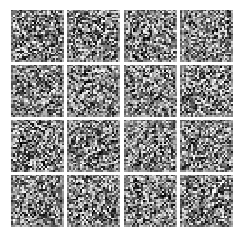

[[4 9 2 7]
 [7 2 1 0]
 [0 5 3 2]
 [8 8 5 9]]

Iter: 0, D: 5.536, G:5.763
Iter: 50, D: 4.96, G:6.546
Iter: 100, D: 5.16, G:6.394
Iter: 150, D: 5.133, G:6.817
Iter: 200, D: 5.124, G:6.302


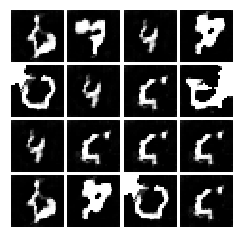

[[6 7 9 8]
 [3 9 0 2]
 [9 0 0 0]
 [6 8 3 0]]

Iter: 250, D: 5.105, G:6.443
Iter: 300, D: 5.186, G:6.276
Iter: 350, D: 5.177, G:6.163
Iter: 400, D: 5.176, G:5.993
Iter: 450, D: 5.099, G:6.167


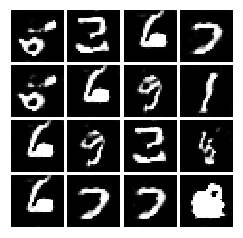

[[5 3 6 7]
 [5 6 9 1]
 [6 9 3 8]
 [6 7 7 2]]

Iter: 500, D: 5.124, G:6.157
Iter: 550, D: 5.196, G:6.073
Iter: 600, D: 5.133, G:6.122
Iter: 650, D: 5.254, G:5.943
Iter: 700, D: 5.233, G:5.927


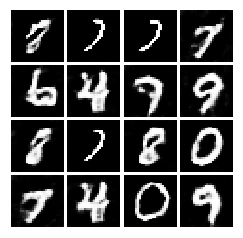

[[8 2 2 7]
 [6 4 7 9]
 [8 2 8 0]
 [7 4 0 9]]

Iter: 750, D: 5.301, G:5.858
Iter: 800, D: 5.28, G:5.816
Iter: 850, D: 5.374, G:5.786
Iter: 900, D: 5.417, G:5.755
Iter: 950, D: 5.331, G:5.76


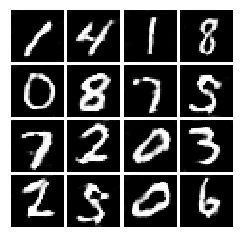

[[1 4 1 8]
 [0 8 7 3]
 [7 2 0 3]
 [2 3 0 6]]

Iter: 1000, D: 5.35, G:5.746
Iter: 1050, D: 5.325, G:5.733
Iter: 1100, D: 5.365, G:5.75
Iter: 1150, D: 5.333, G:5.826
Iter: 1200, D: 5.328, G:5.75


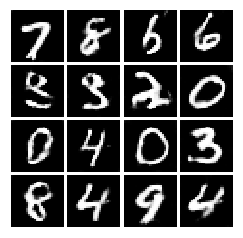

[[7 8 6 6]
 [3 3 2 0]
 [0 4 0 3]
 [8 4 9 4]]

Iter: 1250, D: 5.326, G:5.742
Iter: 1300, D: 5.349, G:5.755
Iter: 1350, D: 5.295, G:5.757
Iter: 1400, D: 5.339, G:5.753
Iter: 1450, D: 5.436, G:5.739


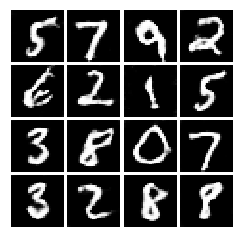

[[5 7 9 2]
 [6 2 1 5]
 [3 8 0 7]
 [3 2 8 8]]

Iter: 1500, D: 5.28, G:5.727
Iter: 1550, D: 5.33, G:5.763
Iter: 1600, D: 5.357, G:5.732
Iter: 1650, D: 5.386, G:5.789
Iter: 1700, D: 5.356, G:5.727


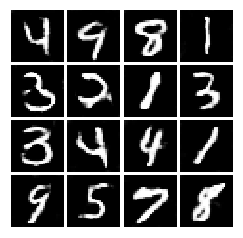

[[4 9 8 1]
 [3 2 1 3]
 [3 4 4 1]
 [9 5 7 8]]

Iter: 1750, D: 5.386, G:5.76
Iter: 1800, D: 5.336, G:5.734
Iter: 1850, D: 5.359, G:5.735
Iter: 1900, D: 5.327, G:5.762
Iter: 1950, D: 5.391, G:5.728


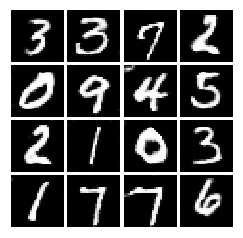

[[3 3 7 2]
 [0 9 4 5]
 [2 1 0 3]
 [1 7 7 6]]

Iter: 2000, D: 5.338, G:5.792
Iter: 2050, D: 5.318, G:5.758
Iter: 2100, D: 5.332, G:5.731
Iter: 2150, D: 5.324, G:5.734
Iter: 2200, D: 5.293, G:5.768


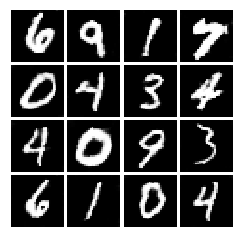

[[6 9 1 7]
 [0 4 3 4]
 [4 0 9 3]
 [6 1 0 4]]

Iter: 2250, D: 5.334, G:5.729
Iter: 2300, D: 5.352, G:5.76
Iter: 2350, D: 5.299, G:5.737
Iter: 2400, D: 5.286, G:5.781
Iter: 2450, D: 5.294, G:5.835


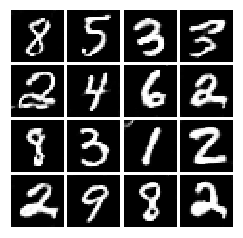

[[8 5 3 3]
 [2 4 6 2]
 [8 3 1 2]
 [2 9 8 2]]

Iter: 2500, D: 5.298, G:5.793
Iter: 2550, D: 5.237, G:5.807
Iter: 2600, D: 5.229, G:5.85
Iter: 2650, D: 5.283, G:5.858
Iter: 2700, D: 5.295, G:5.814


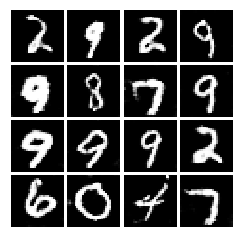

[[2 9 2 9]
 [9 8 7 9]
 [9 9 9 2]
 [6 0 4 7]]

Iter: 2750, D: 5.258, G:5.797
Iter: 2800, D: 5.262, G:5.849
Iter: 2850, D: 5.301, G:5.904
Iter: 2900, D: 5.215, G:5.833
Iter: 2950, D: 5.302, G:5.861


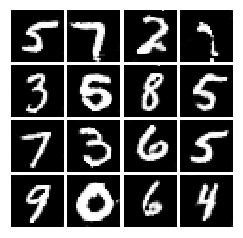

[[5 7 2 7]
 [3 5 8 5]
 [7 3 6 5]
 [9 0 6 4]]

Iter: 3000, D: 5.269, G:5.786
Iter: 3050, D: 5.214, G:5.847
Iter: 3100, D: 5.255, G:5.836
Iter: 3150, D: 5.313, G:5.749
Iter: 3200, D: 5.252, G:5.813


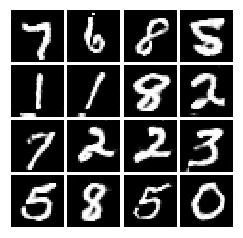

[[7 6 8 5]
 [1 1 8 2]
 [7 2 2 3]
 [5 8 5 0]]

Iter: 3250, D: 5.231, G:5.848
Iter: 3300, D: 5.265, G:5.946
Iter: 3350, D: 5.208, G:5.825
Iter: 3400, D: 5.236, G:5.955
Iter: 3450, D: 5.236, G:5.858


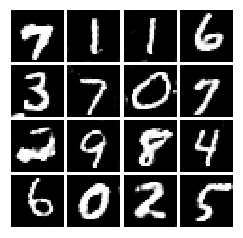

[[7 1 1 6]
 [3 7 0 7]
 [2 9 8 4]
 [6 0 2 5]]

Iter: 3500, D: 5.217, G:5.883
Iter: 3550, D: 5.228, G:5.934
Iter: 3600, D: 5.217, G:5.95
Iter: 3650, D: 5.208, G:5.983
Iter: 3700, D: 5.239, G:6.04


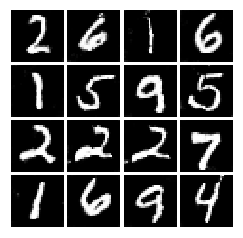

[[2 6 1 6]
 [1 5 9 5]
 [2 2 2 7]
 [1 6 9 4]]

Iter: 3750, D: 5.201, G:5.821
Iter: 3800, D: 5.239, G:6.187
Iter: 3850, D: 5.26, G:5.805
Iter: 3900, D: 5.188, G:5.821
Iter: 3950, D: 5.199, G:5.877


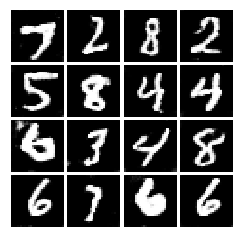

[[7 2 8 2]
 [5 8 4 4]
 [6 3 4 8]
 [6 7 6 6]]

Iter: 4000, D: 5.149, G:5.934
Iter: 4050, D: 5.251, G:5.786
Iter: 4100, D: 5.137, G:6.137
Iter: 4150, D: 5.149, G:6.13
Iter: 4200, D: 5.178, G:5.983


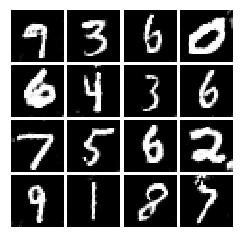

[[9 3 6 0]
 [6 4 3 6]
 [7 5 6 2]
 [9 1 8 7]]

Iter: 4250, D: 5.122, G:6.312
Final images


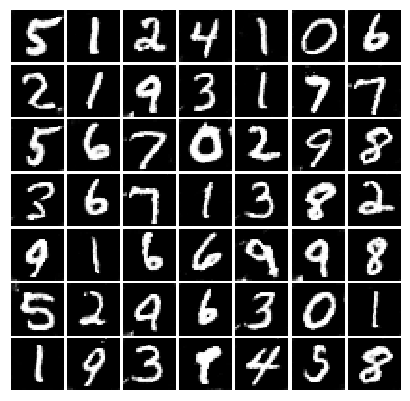

[[5 1 2 4 1 0 6]
 [2 1 9 3 1 7 7]
 [5 6 7 0 2 9 8]
 [3 6 7 1 3 8 2]
 [9 1 6 6 9 9 8]
 [5 2 9 6 3 0 1]
 [1 9 3 1 4 5 8]]


In [45]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,num_epoch=10)

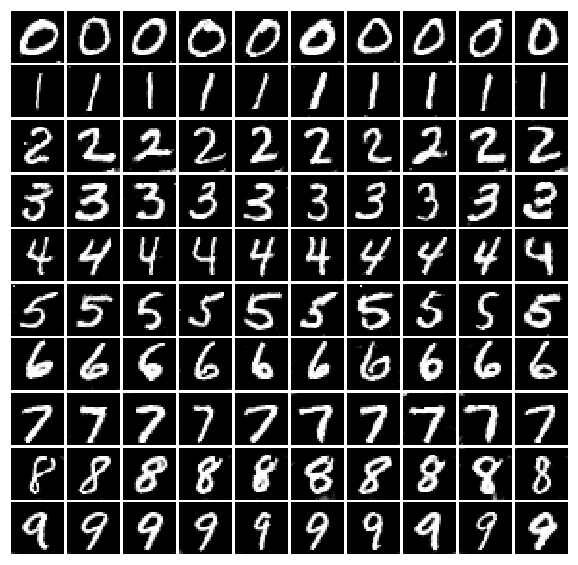

In [66]:
#Standard GAN loss function (Sigmoid + XEnt), about 40 epochs
with tf.variable_scope("") as scope:
    scope.reuse_variables()
    z = sample_noise(100, noise_dim)
    y = tf.one_hot(tf.constant(np.repeat(np.arange(10),10)),10)
    G_sample = generator(z,y).eval()
    show_images(G_sample)
    

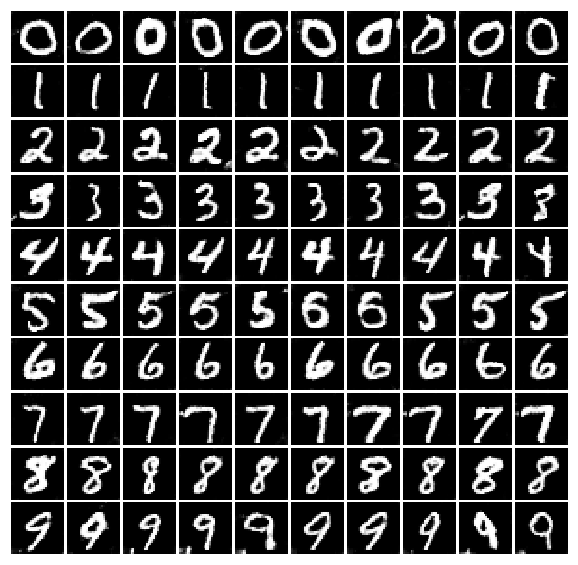

In [46]:
#Softmax gan, 10 epochs
with tf.variable_scope("") as scope:
    scope.reuse_variables()
    z = sample_noise(100, noise_dim)
    y = tf.one_hot(tf.constant(np.repeat(np.arange(10),10)),10)
    G_sample = generator(z,y).eval()
    show_images(G_sample)

# WGAN-GP (Small Extra Credit)

Please only attempt after you have completed everything above.

We'll now look at [Improved Wasserstein GAN](https://arxiv.org/abs/1704.00028) as a newer, more stable alernative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement Algorithm 1 in the paper. 

You'll also need to use a discriminator and corresponding generator without max-pooling. So we cannot use the one we currently have from DCGAN. Pair the DCGAN Generator (from InfoGAN) with the discriminator from [InfoGAN](https://arxiv.org/pdf/1606.03657.pdf) Appendix C.1 MNIST (We don't use Q, simply implement the network up to D). You're also welcome to define a new generator and discriminator in this notebook, in case you want to use the fully-connected pair of D(x) and G(z) you used at the top of this notebook.

Architecture:
* 64 Filters of 4x4, stride 2, LeakyReLU
* 128 Filters of 4x4, stride 2, LeakyReLU
* BatchNorm
* Flatten
* Fully connected 1024, LeakyReLU
* Fully connected size 1

In [22]:
def discriminator(x):
    leaky_relu = lambda x: tf.nn.leaky_relu(x, 0.01)
    
    with tf.variable_scope('discriminator'):
        h = x
        h = tf.reshape(h, (-1, 28,28,1))
        h = tf.layers.conv2d(h, 64, (4,4), (2,2), activation=leaky_relu)
        h = tf.layers.conv2d(h, 128, (4,4), (2,2), activation=leaky_relu)
        h = tf.layers.batch_normalization(h)
        h = tf.layers.flatten(h)
        h = tf.layers.dense(h, 1024, activation=leaky_relu)
        h = tf.layers.dense(h, 1)
        
        logits = h
        return logits
test_discriminator(3411649)

Correct number of parameters in discriminator.


I see something unclear: "logits_real, logits_fake" are discriminators output scores, so I'm not sure if I should put them through sigmoid->xentropy or use as they are, so I tried both versions.

In [40]:
tf.reset_default_graph()

batch_size = 128
# our noise dimension
noise_dim = 96

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator')

D_solver, G_solver = get_solvers()

In [35]:
def wgangp_loss(logits_real, logits_fake, batch_size, x, G_sample):
    """Compute the WGAN-GP loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    - batch_size: The number of examples in this batch
    - x: the input (real) images for this batch
    - G_sample: the generated (fake) images for this batch
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    
    D_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_real, 
                                                                    labels=tf.ones_like(logits_real)))\
           + tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake, 
                                                                    labels=tf.zeros_like(logits_fake)))
        
    G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake, 
                                                                    labels=tf.ones_like(logits_fake)))

    # lambda from the paper
    lam = 10
    
    # random sample of batch_size (tf.random_uniform)
    eps = tf.random_uniform((1,), 0, 1)
    x_hat = eps*x + (1-eps)*G_sample

    # Gradients of Gradients is kind of tricky!
    with tf.variable_scope('',reuse=True) as scope:
        grad_D_x_hat = tf.gradients(discriminator(x_hat), x_hat)

    grad_norm = tf.norm(grad_D_x_hat[0], axis=1)
    grad_pen = lam * tf.reduce_mean((grad_norm-1)**2)
    D_loss += grad_pen


    return D_loss, G_loss

D_loss, G_loss = wgangp_loss(logits_real, logits_fake, 128, x, G_sample)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')

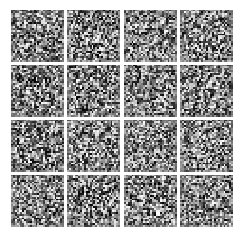


Iter: 0, D: 9.781, G:0.5822
Iter: 50, D: 1.409, G:0.671
Iter: 100, D: 1.896, G:1.138
Iter: 150, D: 1.439, G:0.678
Iter: 200, D: 4.824, G:0.7143


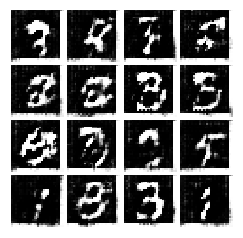


Iter: 250, D: 1.655, G:1.319
Iter: 300, D: 1.796, G:0.513
Iter: 350, D: 2.678, G:0.7291
Iter: 400, D: 1.346, G:0.8654
Iter: 450, D: 3.137, G:0.5646


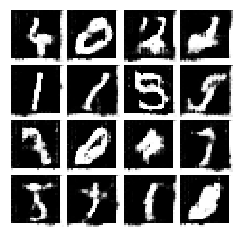


Iter: 500, D: 2.822, G:0.7144
Iter: 550, D: 1.694, G:0.8407
Iter: 600, D: 2.25, G:0.9587
Iter: 650, D: 2.242, G:1.331
Iter: 700, D: 1.566, G:1.142


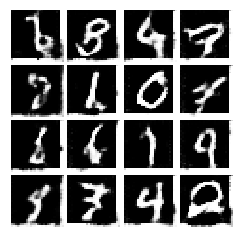


Iter: 750, D: 1.437, G:0.7955
Iter: 800, D: 1.542, G:0.7345
Iter: 850, D: 1.692, G:1.622
Iter: 900, D: 1.474, G:0.7894
Iter: 950, D: 1.441, G:0.9667


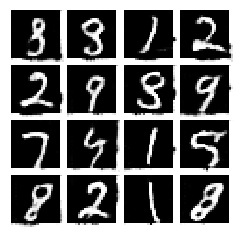


Iter: 1000, D: 1.557, G:0.5427
Iter: 1050, D: 1.424, G:0.8826
Iter: 1100, D: 1.414, G:1.229
Iter: 1150, D: 1.385, G:0.6392
Iter: 1200, D: 1.288, G:0.7844


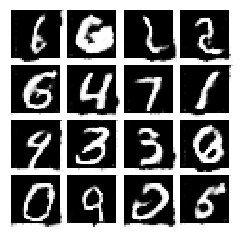


Iter: 1250, D: 1.425, G:0.764
Iter: 1300, D: 1.274, G:0.965
Iter: 1350, D: 1.529, G:1.113
Iter: 1400, D: 1.267, G:0.8731
Iter: 1450, D: 1.389, G:1.038


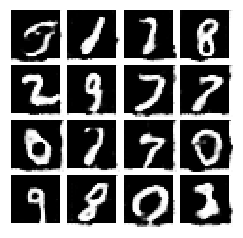


Iter: 1500, D: 1.241, G:0.7127
Iter: 1550, D: 1.332, G:0.8482
Iter: 1600, D: 1.414, G:0.9703
Iter: 1650, D: 1.325, G:0.6464
Iter: 1700, D: 1.405, G:0.7682


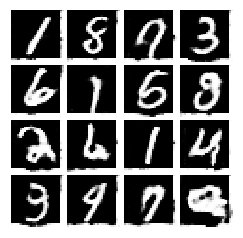


Iter: 1750, D: 1.384, G:0.8166
Iter: 1800, D: 1.355, G:0.8705
Iter: 1850, D: 1.215, G:0.7708
Iter: 1900, D: 1.339, G:1.014
Iter: 1950, D: 1.303, G:0.7587


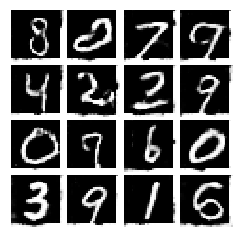


Iter: 2000, D: 1.282, G:0.7972
Iter: 2050, D: 1.303, G:0.7433
Iter: 2100, D: 1.31, G:0.7546
Iter: 2150, D: 1.953, G:0.8091
Iter: 2200, D: 1.412, G:0.7891


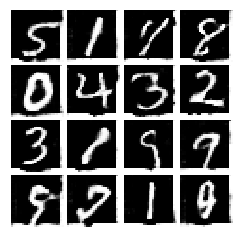


Iter: 2250, D: 1.294, G:0.8232
Iter: 2300, D: 1.365, G:0.9774
Iter: 2350, D: 1.302, G:0.6937
Iter: 2400, D: 1.261, G:1.08
Iter: 2450, D: 1.283, G:0.7961


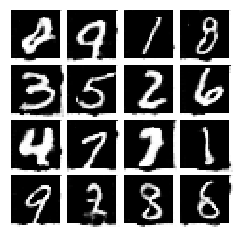


Iter: 2500, D: 1.351, G:0.8777
Iter: 2550, D: 1.303, G:0.7742
Iter: 2600, D: 1.31, G:1.156
Iter: 2650, D: 1.379, G:0.7544
Iter: 2700, D: 1.355, G:0.8149


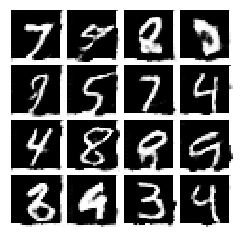


Iter: 2750, D: 1.256, G:0.8636
Iter: 2800, D: 1.396, G:1.12
Iter: 2850, D: 1.369, G:0.9074
Iter: 2900, D: 1.306, G:0.7437
Iter: 2950, D: 1.579, G:0.9425


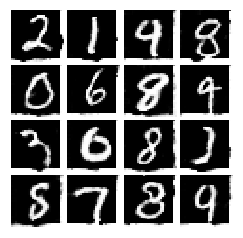


Iter: 3000, D: 1.359, G:0.8876
Iter: 3050, D: 1.274, G:0.823
Iter: 3100, D: 1.251, G:0.964
Iter: 3150, D: 1.272, G:0.9139
Iter: 3200, D: 1.319, G:0.5731


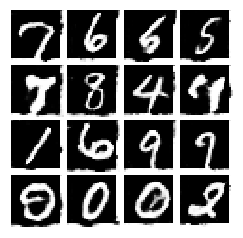


Iter: 3250, D: 1.251, G:0.9257
Iter: 3300, D: 1.313, G:0.8765
Iter: 3350, D: 1.245, G:1.006
Iter: 3400, D: 1.34, G:0.6094
Iter: 3450, D: 1.289, G:0.5879


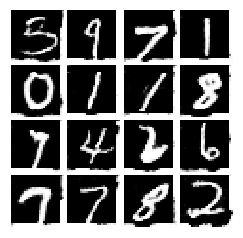


Iter: 3500, D: 1.35, G:0.7489
Iter: 3550, D: 1.25, G:0.9409
Iter: 3600, D: 1.297, G:0.7928
Iter: 3650, D: 1.348, G:1.655
Iter: 3700, D: 1.354, G:0.7242


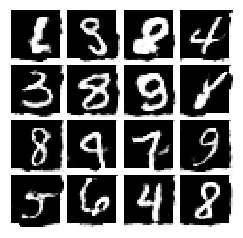


Iter: 3750, D: 1.437, G:1.158
Iter: 3800, D: 1.258, G:0.7822
Iter: 3850, D: 1.324, G:1.071
Iter: 3900, D: 1.33, G:0.8703
Iter: 3950, D: 1.575, G:1.376


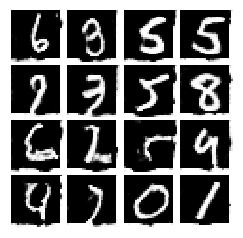


Iter: 4000, D: 1.226, G:0.8197
Iter: 4050, D: 1.299, G:1.069
Iter: 4100, D: 1.273, G:0.9109
Iter: 4150, D: 2.566, G:1.868
Iter: 4200, D: 1.207, G:0.8549


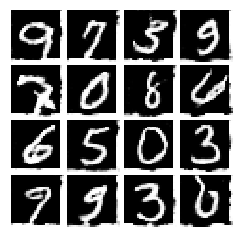


Iter: 4250, D: 1.235, G:1.081
Iter: 4300, D: 1.295, G:0.8262
Iter: 4350, D: 1.402, G:1.122
Iter: 4400, D: 1.269, G:0.9448
Iter: 4450, D: 1.229, G:0.9109


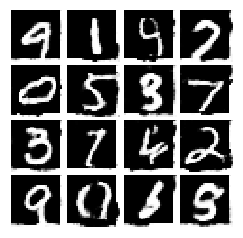


Iter: 4500, D: 1.228, G:0.9045
Iter: 4550, D: 1.184, G:0.8384
Iter: 4600, D: 1.189, G:1.005
Iter: 4650, D: 1.268, G:1.263
Iter: 4700, D: 1.236, G:1.021


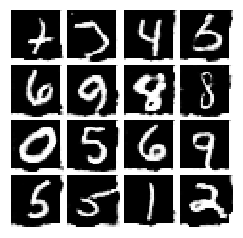


Iter: 4750, D: 1.32, G:1.085
Iter: 4800, D: 1.193, G:0.723
Iter: 4850, D: 1.213, G:0.7121
Iter: 4900, D: 1.304, G:0.9256
Iter: 4950, D: 1.301, G:0.6858


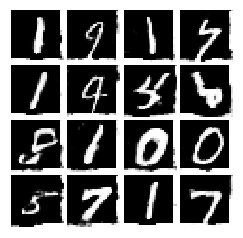


Iter: 5000, D: 1.251, G:0.7105
Iter: 5050, D: 1.25, G:0.8146
Iter: 5100, D: 1.327, G:1.064
Iter: 5150, D: 1.285, G:0.8286
Iter: 5200, D: 1.227, G:0.8537


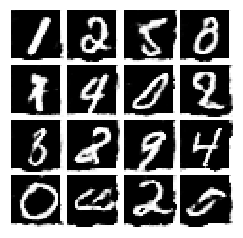


Iter: 5250, D: 1.197, G:0.8773
Iter: 5300, D: 1.425, G:0.7161
Iter: 5350, D: 1.368, G:0.5933
Iter: 5400, D: 1.426, G:0.8574
Iter: 5450, D: 1.474, G:1.648


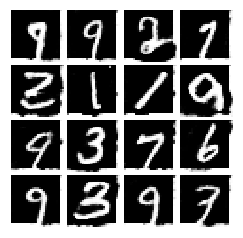


Iter: 5500, D: 1.257, G:0.7476
Iter: 5550, D: 1.137, G:0.9838
Iter: 5600, D: 1.356, G:0.7716
Iter: 5650, D: 1.216, G:0.8574
Iter: 5700, D: 1.213, G:1.044


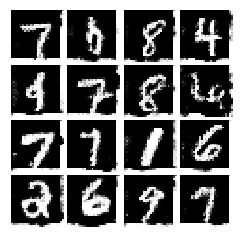


Iter: 5750, D: 2.774, G:0.6408
Iter: 5800, D: 3.101, G:0.6846
Iter: 5850, D: 2.854, G:0.5231
Iter: 5900, D: 2.511, G:0.5786
Iter: 5950, D: 1.846, G:0.6628


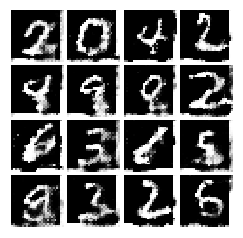


Iter: 6000, D: 1.56, G:0.7145
Iter: 6050, D: 1.451, G:0.7759
Iter: 6100, D: 1.586, G:0.6339
Iter: 6150, D: 1.578, G:0.7591
Iter: 6200, D: 1.425, G:0.7941


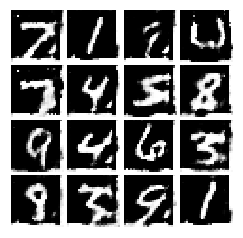


Iter: 6250, D: 1.454, G:0.7225
Iter: 6300, D: 1.445, G:0.6829
Iter: 6350, D: 1.428, G:0.5921
Iter: 6400, D: 1.422, G:0.6271
Iter: 6450, D: 1.465, G:0.6165


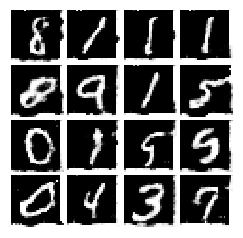


Iter: 6500, D: 1.45, G:0.5524
Iter: 6550, D: 1.493, G:1.059
Iter: 6600, D: 1.437, G:0.6234
Iter: 6650, D: 1.468, G:0.7165
Iter: 6700, D: 1.414, G:0.7656


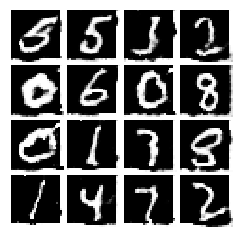


Iter: 6750, D: 1.401, G:0.682
Iter: 6800, D: 1.421, G:0.6324
Iter: 6850, D: 1.413, G:0.6703
Iter: 6900, D: 1.418, G:0.5557
Iter: 6950, D: 1.419, G:0.6487


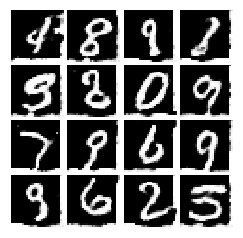


Iter: 7000, D: 1.424, G:0.6507
Iter: 7050, D: 1.41, G:0.7075
Iter: 7100, D: 1.388, G:0.7029
Iter: 7150, D: 1.432, G:0.7047
Iter: 7200, D: 1.386, G:0.6994


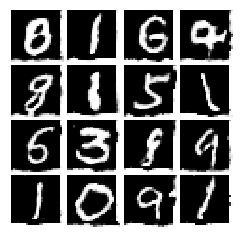


Iter: 7250, D: 1.417, G:0.6192
Iter: 7300, D: 1.407, G:0.7247
Iter: 7350, D: 1.427, G:0.9597
Iter: 7400, D: 1.433, G:0.5365
Iter: 7450, D: 1.413, G:0.6094


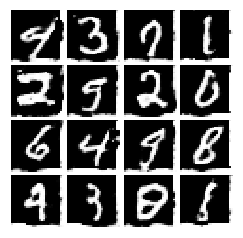


Iter: 7500, D: 1.408, G:0.6175
Iter: 7550, D: 1.413, G:0.6497
Iter: 7600, D: 1.406, G:0.7167
Iter: 7650, D: 1.418, G:0.8621
Iter: 7700, D: 1.457, G:0.4973


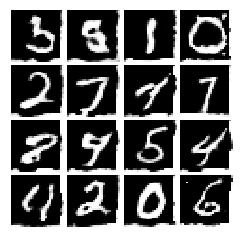


Iter: 7750, D: 1.464, G:0.8619
Iter: 7800, D: 1.395, G:0.7167
Iter: 7850, D: 1.414, G:0.6889
Iter: 7900, D: 1.44, G:0.5457
Iter: 7950, D: 1.427, G:0.6737


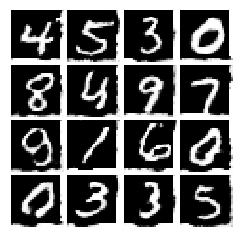


Iter: 8000, D: 1.445, G:0.8674
Iter: 8050, D: 1.424, G:0.6418
Iter: 8100, D: 1.387, G:0.657
Iter: 8150, D: 1.418, G:0.7873
Iter: 8200, D: 1.395, G:0.6639


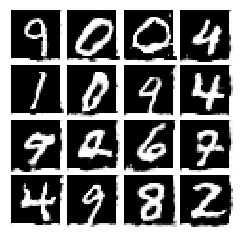


Iter: 8250, D: 1.397, G:0.7059
Iter: 8300, D: 1.39, G:0.6665
Iter: 8350, D: 1.438, G:0.6029
Iter: 8400, D: 1.381, G:0.7365
Iter: 8450, D: 1.393, G:0.6906


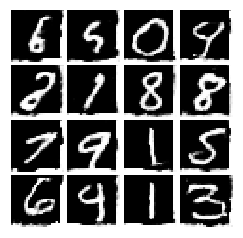


Iter: 8500, D: 1.381, G:0.8092
Iter: 8550, D: 1.405, G:0.7171
Final images


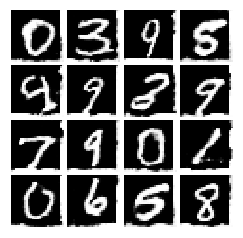

In [37]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step,batch_size=128,num_epoch=20)

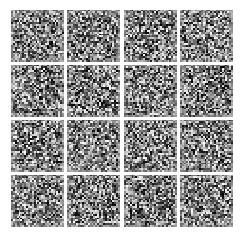


Iter: 0, D: 8.184, G:-0.2883
Iter: 50, D: -2.267, G:-4.94
Iter: 100, D: -1.039, G:-12.14
Iter: 150, D: -1.832, G:-6.303
Iter: 200, D: -1.109, G:-4.392


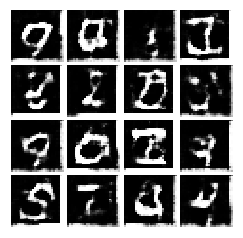


Iter: 250, D: -1.336, G:-3.851
Iter: 300, D: -1.153, G:-6.041
Iter: 350, D: -1.613, G:-12.55
Iter: 400, D: -0.0743, G:-9.814
Iter: 450, D: -0.7271, G:-6.756


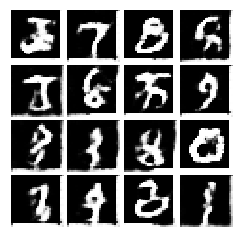


Iter: 500, D: -0.8125, G:-5.518
Iter: 550, D: 0.07206, G:-10.74
Iter: 600, D: -0.1283, G:-7.092
Iter: 650, D: -0.4329, G:-8.01
Iter: 700, D: 0.197, G:-7.491


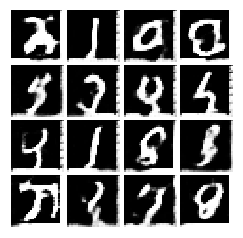


Iter: 750, D: -0.2216, G:-13.21
Iter: 800, D: -0.432, G:-6.466
Iter: 850, D: -0.5163, G:-2.714
Iter: 900, D: 0.1183, G:-2.769
Iter: 950, D: -0.3542, G:-5.683


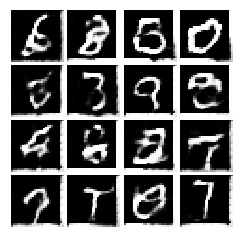


Iter: 1000, D: -0.5087, G:-9.331
Iter: 1050, D: -0.5226, G:1.249
Iter: 1100, D: -0.3268, G:-8.476
Iter: 1150, D: -0.5322, G:-10.4
Iter: 1200, D: 0.4772, G:2.733


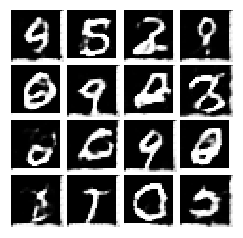


Iter: 1250, D: -0.6217, G:-4.121
Iter: 1300, D: -0.499, G:-16.28
Iter: 1350, D: -0.1732, G:-20.72
Iter: 1400, D: -1.117, G:-9.923
Iter: 1450, D: -0.9739, G:-7.655


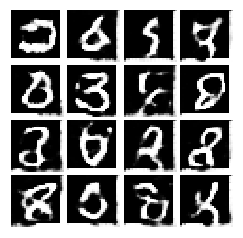


Iter: 1500, D: -0.2077, G:-8.763
Iter: 1550, D: 0.03791, G:0.4783
Iter: 1600, D: -0.09556, G:-8.94
Iter: 1650, D: -0.3136, G:-11.7
Iter: 1700, D: 0.4873, G:-2.376


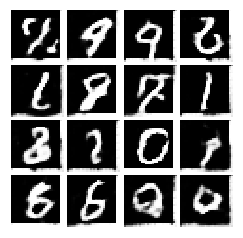


Iter: 1750, D: 0.2797, G:-12.24
Iter: 1800, D: -0.4577, G:-11.51
Iter: 1850, D: -0.5338, G:-4.511
Iter: 1900, D: -0.7824, G:4.462
Iter: 1950, D: -0.3669, G:-9.595


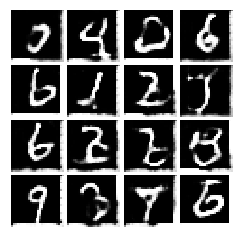


Iter: 2000, D: -0.8221, G:-2.551
Iter: 2050, D: 0.6479, G:-11.21
Iter: 2100, D: -1.468, G:-20.7
Iter: 2150, D: -0.2464, G:-9.754
Iter: 2200, D: 0.5095, G:-5.222


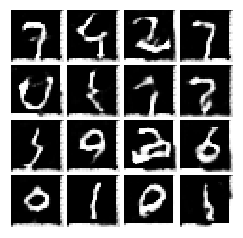


Iter: 2250, D: -0.2226, G:-8.615
Iter: 2300, D: 0.1906, G:-5.658
Iter: 2350, D: -0.8046, G:-7.186
Iter: 2400, D: -0.7289, G:-17.24
Iter: 2450, D: -0.2139, G:-9.473


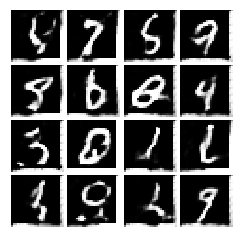


Iter: 2500, D: -0.8592, G:0.6034
Iter: 2550, D: -0.07779, G:-9.436
Iter: 2600, D: -0.6052, G:-9.424
Iter: 2650, D: -0.305, G:-8.503
Iter: 2700, D: 0.2425, G:-4.717


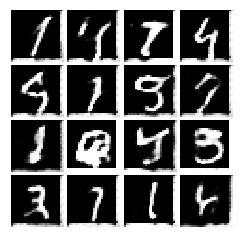


Iter: 2750, D: -0.4471, G:-8.809
Iter: 2800, D: -1.058, G:-2.343
Iter: 2850, D: -0.2959, G:-2.441
Iter: 2900, D: -0.7983, G:-6.338
Iter: 2950, D: -0.2255, G:8.36


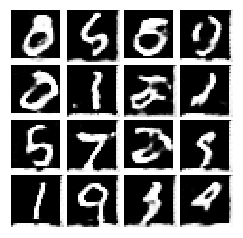


Iter: 3000, D: -1.052, G:-2.537
Iter: 3050, D: -0.2887, G:-6.426
Iter: 3100, D: -0.6975, G:0.6684
Iter: 3150, D: -0.2513, G:1.674
Iter: 3200, D: -0.1957, G:-9.883


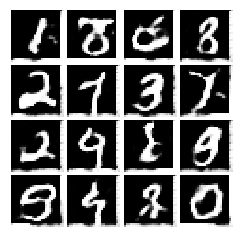


Iter: 3250, D: 0.1292, G:-6.878
Iter: 3300, D: -0.2058, G:-7.238
Iter: 3350, D: 0.5867, G:-6.025
Iter: 3400, D: -0.7157, G:-17.47
Iter: 3450, D: 0.08177, G:-9.534


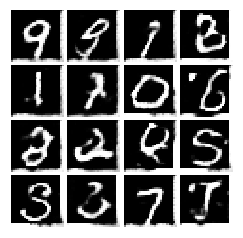


Iter: 3500, D: -0.348, G:-6.731
Iter: 3550, D: -0.08597, G:-6.043
Iter: 3600, D: -0.6089, G:-4.723
Iter: 3650, D: 0.001421, G:-14.86
Iter: 3700, D: 0.1249, G:-0.3642


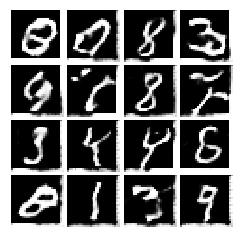


Iter: 3750, D: -0.1267, G:-3.073
Iter: 3800, D: -0.02232, G:-5.479
Iter: 3850, D: -0.08533, G:-10.44
Iter: 3900, D: -0.584, G:-13.32
Iter: 3950, D: -0.2365, G:-1.219


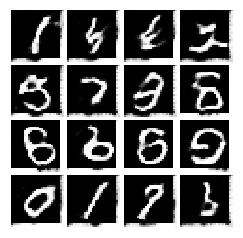


Iter: 4000, D: -0.4699, G:-2.21
Iter: 4050, D: 0.2796, G:-1.831
Iter: 4100, D: -0.4513, G:-9.575
Iter: 4150, D: 0.3374, G:-3.115
Iter: 4200, D: -0.08692, G:-3.279


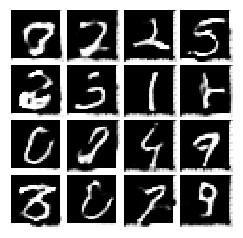


Iter: 4250, D: -0.1758, G:-6.894
Iter: 4300, D: -0.1395, G:-8.052
Iter: 4350, D: 0.0518, G:-1.717
Iter: 4400, D: -0.8979, G:-4.275
Iter: 4450, D: -0.01445, G:-12.4


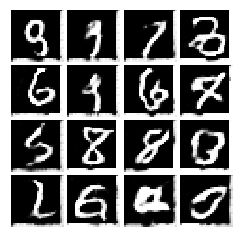


Iter: 4500, D: -0.93, G:-8.127
Iter: 4550, D: -0.6293, G:-17.57
Iter: 4600, D: 0.2993, G:-6.561
Iter: 4650, D: 0.07425, G:-2.688
Iter: 4700, D: -0.3497, G:4.385


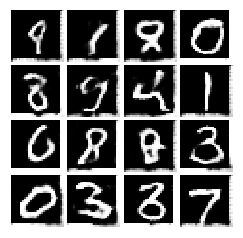


Iter: 4750, D: -0.05616, G:-1.554
Iter: 4800, D: -1.282, G:0.2829
Iter: 4850, D: -0.891, G:-18.22
Iter: 4900, D: -0.2916, G:-13.4
Iter: 4950, D: -0.3788, G:-6.895


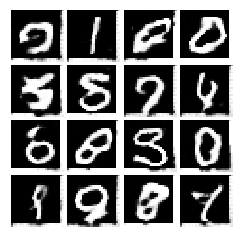


Iter: 5000, D: 0.5572, G:-2.844
Iter: 5050, D: -0.234, G:-6.267
Iter: 5100, D: -0.3981, G:0.9293
Iter: 5150, D: 0.2411, G:-3.719
Iter: 5200, D: -0.01766, G:-9.457


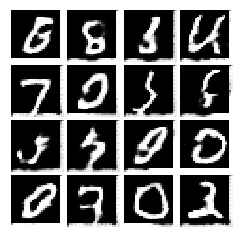


Iter: 5250, D: -0.545, G:-6.695
Iter: 5300, D: 0.3369, G:-7.759
Iter: 5350, D: -0.2678, G:-5.671
Iter: 5400, D: -0.4728, G:13.64
Iter: 5450, D: -0.3244, G:-10.38


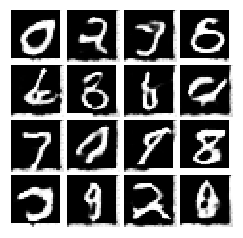


Iter: 5500, D: -0.2791, G:-6.56
Iter: 5550, D: -0.5697, G:-12.81
Iter: 5600, D: -0.2955, G:-6.871
Iter: 5650, D: -0.1043, G:-6.574
Iter: 5700, D: -0.6143, G:-13.57


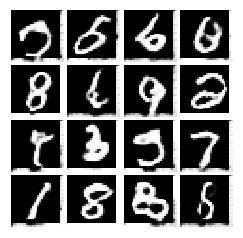


Iter: 5750, D: -0.1401, G:-10.32
Iter: 5800, D: 0.3175, G:-4.342
Iter: 5850, D: -0.2949, G:-1.162
Iter: 5900, D: -0.3171, G:-8.153
Iter: 5950, D: -0.3861, G:-8.772


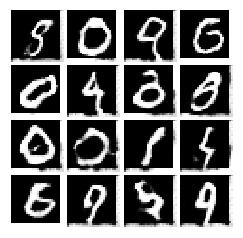


Iter: 6000, D: 0.1955, G:-10.07
Iter: 6050, D: -0.1027, G:-5.263
Iter: 6100, D: -0.3238, G:-6.216
Iter: 6150, D: -0.2187, G:-0.09672
Iter: 6200, D: -0.1665, G:-2.229


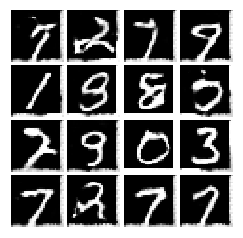


Iter: 6250, D: -0.4437, G:-1.209
Iter: 6300, D: 0.2436, G:-7.347
Iter: 6350, D: -0.1229, G:-8.831
Iter: 6400, D: -0.8911, G:-15.81
Iter: 6450, D: -0.1456, G:-16.61


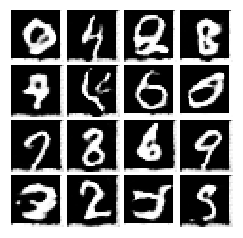


Iter: 6500, D: -0.1536, G:-4.21
Iter: 6550, D: 0.05161, G:-1.903
Iter: 6600, D: 0.5114, G:-4.668
Iter: 6650, D: 0.4361, G:-6.332
Iter: 6700, D: -0.3235, G:-6.857


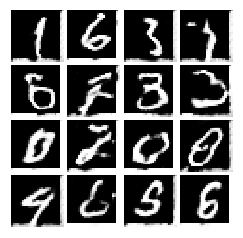


Iter: 6750, D: -0.709, G:-1.127
Iter: 6800, D: -0.5018, G:-7.723
Iter: 6850, D: 0.008486, G:-5.033
Iter: 6900, D: -0.1254, G:-9.772
Iter: 6950, D: 0.1015, G:-15.24


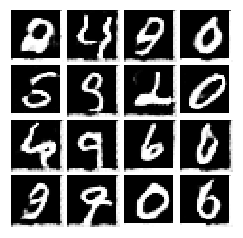


Iter: 7000, D: -0.3758, G:-8.354
Iter: 7050, D: 0.1095, G:4.066
Iter: 7100, D: -0.1661, G:5.937
Iter: 7150, D: -0.2666, G:-8.857
Iter: 7200, D: -0.1837, G:-3.945


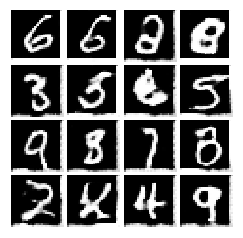


Iter: 7250, D: -0.3796, G:-6.572
Iter: 7300, D: -0.07619, G:-0.5242
Iter: 7350, D: -0.266, G:-7.735
Iter: 7400, D: -0.1434, G:-7.051
Iter: 7450, D: 0.04236, G:-0.8646


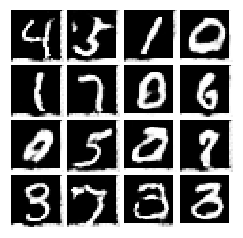


Iter: 7500, D: -0.3424, G:-4.075
Iter: 7550, D: -0.4186, G:-3.051
Iter: 7600, D: -0.8693, G:-2.299
Iter: 7650, D: 0.123, G:-1.642
Iter: 7700, D: 0.2648, G:-4.579


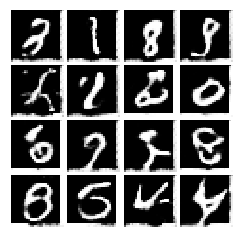


Iter: 7750, D: -0.03601, G:-2.754
Iter: 7800, D: -0.2173, G:-9.944
Iter: 7850, D: 0.2899, G:-10.76
Iter: 7900, D: -0.3889, G:-7.81
Iter: 7950, D: 0.08883, G:-0.3765


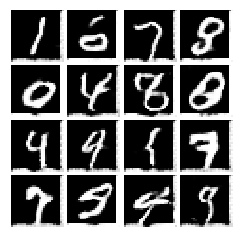


Iter: 8000, D: -0.2208, G:-5.072
Iter: 8050, D: -0.3093, G:-5.825
Iter: 8100, D: -0.1194, G:-7.122
Iter: 8150, D: -0.5741, G:-10.75
Iter: 8200, D: -0.1561, G:-3.682


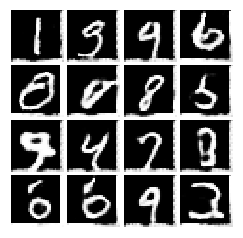


Iter: 8250, D: -0.2045, G:0.4163
Iter: 8300, D: -0.589, G:-6.575
Iter: 8350, D: -0.6591, G:-10.07
Iter: 8400, D: -0.2445, G:-6.222
Iter: 8450, D: -0.2857, G:0.2464


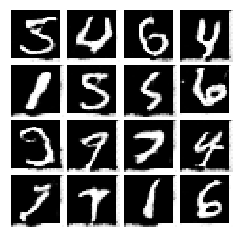


Iter: 8500, D: -0.3295, G:-5.006
Iter: 8550, D: -0.2329, G:2.38
Final images


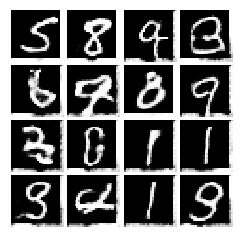

In [42]:
def wgangp_loss(logits_real, logits_fake, batch_size, x, G_sample):
    """Compute the WGAN-GP loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    - batch_size: The number of examples in this batch
    - x: the input (real) images for this batch
    - G_sample: the generated (fake) images for this batch
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    D_loss = tf.reduce_mean(logits_fake) - tf.reduce_mean(logits_real)
    G_loss = -tf.reduce_mean(logits_fake)

    # lambda from the paper
    lam = 10
    
    # random sample of batch_size (tf.random_uniform)
    eps = tf.random_uniform((1,), 0, 1)
    x_hat = eps*x + (1-eps)*G_sample

    # Gradients of Gradients is kind of tricky!
    with tf.variable_scope('',reuse=True) as scope:
        grad_D_x_hat = tf.gradients(discriminator(x_hat), x_hat)

    grad_norm = tf.norm(grad_D_x_hat[0], axis=1)
    grad_pen = lam * tf.reduce_mean((grad_norm-1)**2)
    D_loss += grad_pen


    return D_loss, G_loss

D_loss, G_loss = wgangp_loss(logits_real, logits_fake, 128, x, G_sample)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step,batch_size=128,num_epoch=20)